In [1]:
from localreg import *
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
import re
from matplotlib.lines import Line2D
from matplotlib import gridspec
from numpy import diff

A quick function for lowess smoothing of cM values to get rid of noise:

In [106]:
def lowess_smooth_link(df, sextype):
    start = 0.01
    smoothed = pd.DataFrame(sm.nonparametric.lowess(exog=df["POS"], endog=df[sextype], frac = start))
    smoothed.columns = ["POS", sextype]
    while start < 1:
        if ( smoothed["POS"].is_monotonic or 
        smoothed["POS"].iloc[::-1].is_monotonic ) and ( smoothed[sextype].is_monotonic or 
                                                  smoothed[sextype].iloc[::-1].is_monotonic ):
            break
        else:
            start = start + 0.01
            smoothed = pd.DataFrame(sm.nonparametric.lowess(exog=df["POS"], endog=df[sextype], frac = start))
            smoothed.columns = ["POS", sextype]
    smoothed = smoothed.sort_values("POS").reset_index(drop=True)
    smoothed.loc[smoothed[sextype] < 0, sextype] = 0
    df["smoothed_" + sextype] = smoothed[sextype]
    df["lowess_smoothing_fraction_" + sextype] = start
    df = df.sort_values("POS").reset_index(drop=True)

No MareyMaps are output by default in Lep-MAP3 only mode so we'll make some pretty ones here now:


In [ ]:
%%bash
zcat ../../convert_snpchip_coords/lepwrap_apal/2_Filtering/data.filtered.lepmap3.gz \
    | cut -f1,2 | awk '(NR>=7)' > ../../convert_snpchip_coords/lepwrap_apal/snps.txt

In [168]:
snps = pd.read_csv("../../convert_snpchip_coords/lepwrap_apal/snps.txt", sep = "\t")
snps = snps.reset_index(drop=False)
snps.columns = ["Marker", "CHR", "POS"]
snps["Marker"] = snps["Marker"] + 1

In [169]:
homologouschr = {"hic_scaffold_4":"LG1", "hic_scaffold_2":"LG2", "hic_scaffold_10":"LG3", 
                 "hic_scaffold_15":"LG4", "hic_scaffold_17":"LG5", "hic_scaffold_20":"LG6", 
                 "hic_scaffold_31":"LG7", "hic_scaffold_30":"LG8", "hic_scaffold_6":"LG9", 
                 "hic_scaffold_35":"LG10", "hic_scaffold_5":"LG11", "hic_scaffold_11":"LG12", 
                 "hic_scaffold_21":"LG13", "hic_scaffold_1":"LG14"}

In [170]:
snps = snps[snps["CHR"].isin(list(homologouschr.keys()))]

In [171]:
acerrename = {"LG4":"LG1", "LG2":"LG2", "LG6":"LG3", 
                 "LG3":"LG4", "LG1":"LG5", "LG5":"LG6", 
                 "LG8":"LG7", "LG11":"LG8", "LG10":"LG9", 
                 "LG12":"LG10", "LG14":"LG11", "LG13":"LG12", 
                 "LG7":"LG13", "LG9":"LG14"}

Generating input for MareyMap:

In [172]:
apal = pd.DataFrame()
for parts in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]:
    tmp = pd.read_csv("../../convert_snpchip_coords/lepwrap_apal/7_Distances/ordered." + str(parts) + ".distances", 
                sep = "\t", comment = "#", names =  ["Marker", "MALE", "FEMALE", 0, 1])
    tmp = tmp.merge(snps, how = "left", on = "Marker")
    sexavg = pd.read_csv("../../convert_snpchip_coords/lepwrap_apal/7_DistancesSexAverage/ordered." + str(parts) + ".sexavg", 
                sep = "\t", comment = "#", names =  ["Marker", "average", 0, 1, 2])
    sexavg = sexavg.merge(snps, how = "left", on = "Marker")
    tmp["SEXAVG"] = sexavg["average"]
    tmp = tmp[["CHR", "POS", "MALE", "FEMALE", "SEXAVG"]]
    tmp = tmp[tmp["CHR"] == pd.DataFrame(tmp["CHR"].value_counts().head(1)).index[0]].reset_index(drop=True)
    apal = pd.concat([apal, tmp]).reset_index(drop=True)
apal = apal.sort_values(["CHR", "POS"]).reset_index(drop=True)
apal["Marker"] = apal["CHR"] + "_" + apal["POS"].astype(int).astype(str)
acer = pd.read_csv("../../acer_cnat_dcyl_ssid_assembly/acer_linkage_scaffolding/lepwrap_denovo2/16_MareyMapsTrimmed/data.marey.trimmed.gz", 
            compression= "gzip", sep = "\t", header = None, names = ["CHR", "POS", "NA", "NA1", "MALE", "FEMALE"])
acer["SEXAVG"] = ( acer["MALE"] + acer["FEMALE"] ) / 2
acer = acer[~acer["CHR"].str.contains("#")].reset_index(drop=True)
acer = acer[["CHR", "POS", "MALE", "FEMALE", "SEXAVG"]]
acer = acer.sort_values(["CHR", "POS"]).reset_index(drop=True)
acer = acer.replace({"CHR": acerrename})
acer["Marker"] = acer["CHR"] + "_" + acer["POS"].astype(int).astype(str)

In [54]:
for sex in ["MALE", "FEMALE", "SEXAVG"]:
    apal["POS"] = apal["POS"].astype(int)
    apal["Marker"] = apal["CHR"] + "_" + apal["POS"].astype(str)
    apal["set"] = "Acropora palmata"
    tmp = apal[["set", "CHR", "Marker", "POS", sex]]
    tmp.columns = ["set", "map", "mkr", "phys", "gen"]
    tmp["map"] = tmp["map"].astype(str)
    tmp["mkr"] = tmp["mkr"].astype(str)
    tmp.set_index("set").to_csv("../apal_" + sex + ".txt", sep = " ", quoting=csv.QUOTE_NONNUMERIC)
    acer["POS"] = acer["POS"].astype(int)
    acer["Marker"] = acer["CHR"] + "_" + acer["POS"].astype(str)
    acer["set"] = "Acropora cervicornis"
    tmp = acer[["set", "CHR", "Marker", "POS", sex]]
    tmp.columns = ["set", "map", "mkr", "phys", "gen"]
    tmp["map"] = tmp["map"].astype(str)
    tmp["mkr"] = tmp["mkr"].astype(str)
    tmp.set_index("set").to_csv("../acer_" + sex + ".txt", sep = " ", quoting=csv.QUOTE_NONNUMERIC)

/tmp/ipykernel_2582084/2748922873.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp["map"] = tmp["map"].astype(str)
/tmp/ipykernel_2582084/2748922873.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp["mkr"] = tmp["mkr"].astype(str)
/tmp/ipykernel_2582084/2748922873.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [173]:
fullmap = []
malemap = []
femalemap = []
for i in apal["CHR"].unique():
    malemap = malemap + [apal["FEMALE"][apal["CHR"] == i].max()]
    fullmap = fullmap + [apal["SEXAVG"][apal["CHR"] == i].max()]
    femalemap = femalemap + [apal["MALE"][apal["CHR"] == i].max()]
    print(i, str(apal["FEMALE"][apal["CHR"] == i].max()) + "cM", len(apal["FEMALE"][apal["CHR"] == i]),
          str(apal["SEXAVG"][apal["CHR"] == i].max()) + "cM", len(apal["SEXAVG"][apal["CHR"] == i]),
          str(apal["MALE"][apal["CHR"] == i].max()) + "cM", len(apal["MALE"][apal["CHR"] == i]),)
print(sum(malemap))
print(sum(fullmap))
print(sum(femalemap))

hic_scaffold_1 59.688cM 150 77.914cM 150 97.828cM 150
hic_scaffold_10 40.18cM 171 74.401cM 171 109.241cM 171
hic_scaffold_11 41.219cM 82 66.931cM 82 93.916cM 82
hic_scaffold_15 52.659cM 134 88.267cM 134 124.591cM 134
hic_scaffold_17 36.647cM 162 65.385cM 162 95.01cM 162
hic_scaffold_2 42.181cM 155 79.178cM 155 116.881cM 155
hic_scaffold_20 39.206cM 162 72.52cM 162 106.435cM 162
hic_scaffold_21 28.922cM 112 53.627cM 112 79.951cM 112
hic_scaffold_30 27.673cM 142 59.608cM 142 92.01cM 142
hic_scaffold_31 30.512cM 141 56.317cM 141 82.652cM 141
hic_scaffold_35 30.614cM 143 66.011cM 143 102.659cM 143
hic_scaffold_4 54.045cM 318 100.303cM 318 148.285cM 318
hic_scaffold_5 51.938cM 113 81.742cM 113 115.024cM 113
hic_scaffold_6 47.708cM 129 71.218cM 129 96.197cM 129
583.192
1013.4219999999998
1460.6800000000003


In [9]:
fullmap = []
malemap = []
femalemap = []
for i in acer["CHR"].unique():
    malemap = malemap + [acer["MALE"][acer["CHR"] == i].max()]
    fullmap = fullmap + [acer["SEXAVG"][acer["CHR"] == i].max()]
    femalemap = femalemap + [acer["FEMALE"][acer["CHR"] == i].max()]
    print(i, str(acer["MALE"][acer["CHR"] == i].max()) + "cM", len(acer["MALE"][acer["CHR"] == i]),
          str(acer["SEXAVG"][acer["CHR"] == i].max()) + "cM", len(acer["SEXAVG"][acer["CHR"] == i]),
          str(acer["FEMALE"][acer["CHR"] == i].max()) + "cM", len(acer["FEMALE"][acer["CHR"] == i]),)
print(sum(malemap))
print(sum(fullmap))
print(sum(femalemap))

LG5 53.798cM 562 81.041cM 562 108.284cM 562
LG9 48.513cM 340 63.7265cM 340 78.94cM 340
LG8 44.653cM 310 69.8015cM 310 94.95cM 310
LG10 39.534cM 256 64.235cM 256 88.936cM 256
LG12 43.285cM 231 62.173cM 231 81.061cM 231
LG11 19.067cM 170 40.335499999999996cM 170 61.604cM 170
LG2 50.62cM 495 73.613cM 495 96.606cM 495
LG4 54.478cM 433 72.034cM 433 89.59cM 433
LG1 73.092cM 442 97.25200000000001cM 442 121.412cM 442
LG6 27.417cM 340 51.745cM 340 76.073cM 340
LG3 46.007cM 356 68.3045cM 356 90.602cM 356
LG13 20.428cM 277 46.077cM 277 71.726cM 277
LG7 33.673cM 305 60.6635cM 305 87.654cM 305
LG14 47.375cM 342 76.3595cM 342 105.344cM 342
601.94
927.3610000000001
1252.7820000000002


In [124]:
aclg1 = acer[acer["CHR"] == "LG1"].reset_index(drop=True)
aclg1["Mb"] = aclg1["POS"]/1000000
aclg8 = acer[acer["CHR"] == "LG8"].reset_index(drop=True)
aclg8["Mb"] = aclg8["POS"]/1000000
aclg8[~aclg8["Marker"].isin(tmp["mkr"].tolist())]
aclg3 = acer[acer["CHR"] == "LG3"].reset_index(drop=True)
aclg3["Mb"] = aclg3["POS"]/1000000
aclg13 = acer[acer["CHR"] == "LG13"].reset_index(drop=True)
aclg13["Mb"] = aclg13["POS"]/1000000
apscaf4 = apal[apal["CHR"]=="hic_scaffold_4"].reset_index(drop=True)
apscaf4["Mb"] = apscaf4["POS"]/1000000
apscaf30 = apal[apal["CHR"]=="hic_scaffold_30"].reset_index(drop=True)
apscaf30["Mb"] = apscaf30["POS"]/1000000
apscaf10 = apal[apal["CHR"]=="hic_scaffold_10"].reset_index(drop=True)
apscaf10["Mb"] = apscaf10["POS"]/1000000
apscaf21 = apal[apal["CHR"]=="hic_scaffold_21"].reset_index(drop=True)
apscaf21["Mb"] = apscaf21["POS"]/1000000

In [13]:
%%bash
cat ../repeatmask_lepwrap_assembly.sh
sbatch ../repeatmask_lepwrap_assembly.sh

#!/bin/bash
#SBATCH --nodes=1
#SBATCH --ntasks=40
#SBATCH --mem=300GB
#SBATCH --time=48:00:00
#SBATCH --job-name=repeatmasker

cd ~
source ~/.bashrc
cd /storage/group/ibb3/default/acer_cnat_dcyl_ssid_assembly/funannotate_annotation/acer_lepwrap_annotation/annotate_results/

conda activate repeatmasker407

RepeatMasker \
    -lib /storage/group/ibb3/default/acer_cnat_dcyl_ssid_assembly/acer_repeats/AP.repeatlib.fa \
    -engine ncbi \
    -parallel 40 \
    -gff -xsmall -s \
    -poly \
    -dir ./acer_softmasked \
    Acropora_cervicornis.scaffolds.fa

conda activate assembly
samtools faidx Acropora_cervicornis.scaffolds.fa


sbatch: slurm_job_submit: No account set, using default acct: open


Submitted batch job 7059680


In [15]:
%%bash
source ~/.bashrc
conda activate repeatmasker407
cd /storage/group/ibb3/default/acer_cnat_dcyl_ssid_assembly/funannotate_annotation/acer_lepwrap_annotation/annotate_results/acer_softmasked/
perl /storage/group/ibb3/default/tools/RepeatMasker/util/buildSummary.pl \
    -useAbsoluteGenomeSize Acropora_cervicornis.scaffolds.fa.out \
    > Acropora_cervicornis.scaffolds.fa.out.detailed

perl /storage/group/ibb3/default/tools/RepeatMasker/util/calcDivergenceFromAlign.pl \
    -s example \
    Acropora_cervicornis.scaffolds.fa.cat.gz
    
perl /storage/group/ibb3/default/tools/RepeatMasker/util/createRepeatLandscape.pl \
    -g 305412111 -div example > example.html

..................................................................................................................................................................................................................................................................................................................................................................................................................................................................................Parsing example
DNA/Academ-1 will not be graphed!
DNA/Academ-H will not be graphed!
DNA/Sola-3 will not be graphed!
DNA/Crypton-A will not be graphed!
DNA/IS3EU will not be graphed!
DNA/Academ-2 will not be graphed!
DNA/Ginger-2 will not be graphed!


In [418]:
!cat /storage/group/ibb3/default/genome_annotation/RepeatModel_Mask/Apalm_run3_hic/Apalm_assembly_v3.0_200415.fa.out \
    | tr -s " " | tail -n+4 | sed "s/^/ /g" \
    | tr -s " " | cut -d" " -f6,7,8,12 | sed "s/?//g" | cut -d"/" -f1 \
    | tr " " "\t" | grep "^hic_scaffold" \
    > ./ap_repeats.bed

In [16]:
!cat /storage/group/ibb3/default/acer_cnat_dcyl_ssid_assembly/funannotate_annotation/acer_lepwrap_annotation/annotate_results/acer_softmasked/Acropora_cervicornis.scaffolds.fa.out \
    | tr -s " " | tail -n+4 | sed "s/^/ /g" \
    | tr -s " " | cut -d" " -f6,7,8,12 | sed "s/?//g" | cut -d"/" -f1 \
    | tr " " "\t" | grep "^LG" \
    > ./ac_repeats.bed

In [17]:
%%bash
for spp in ap ac; do
    for i in SINE LINE LTR DNA Unknown; do
        grep "${i}" ./${spp}_repeats.bed \
            | cut -f1-3 > ./${spp}_${i}_repeats.bed
    done
done

In [11]:
for spp in ["ap", "ac"]:
    for i in ["SINE", "LINE", "LTR", "DNA", "Unknown"]:
        repeats = pd.read_csv("./" + spp + "_" + i + "_repeats.bed", sep = "\t", header = None)
        repeats["length"] = repeats[2] - repeats[1]
        #repeats["sort"] = repeats[0].str.split("_", n = 1, expand = True)[1]
        #repeats["sort"] = repeats["sort"].astype(int)
        #repeats = repeats.sort_values(["sort", 1]).reset_index(drop=True)
        repeats[[0,1,2,"length"]].set_index(0).to_csv("./" + spp + "_" + i + "_repeats_sum.bed", 
                                                      sep = "\t", header = None)

In [29]:
%%bash
source ~/.bashrc
conda activate ipyrad
bioawk -c fastx '{print $name"\t0\t"length($seq)}' /storage/group/ibb3/default/AP_AC_genome_seqs/dovetail_Apalm/HiC_improvement/Apalm_assembly_v3.1_200911.masked.fasta \
    > ap.full.bed
bioawk -c fastx '{print $name"\t0\t"length($seq)}' /storage/group/ibb3/default/acer_cnat_dcyl_ssid_assembly/funannotate_annotation/acer_lepwrap_annotation/annotate_results/acer_softmasked/Acropora_cervicornis.scaffolds.fa.masked \
    > ac.full.bed

for spp in ap ac; do
    bedtools makewindows \
        -b ${spp}.full.bed \
        -w 500000 -s 5000 > ${spp}.windows.bed
    for i in SINE LINE LTR DNA Unknown; do
        bedtools intersect -a ${spp}.windows.bed \
            -b ./${spp}_${i}_repeats_sum.bed -wao \
            > ./${spp}_${i}.windowed.repeat_content.bed
    done
done

ERROR: This cross-compiler package contains no program /storage/group/ibb3/default/.conda/envs/ipyrad/bin/x86_64-conda_cos6-linux-gnu-cc
ERROR: activate-gcc_linux-64.sh failed, see above for details


In [174]:
apallengths = pd.read_csv("ap.full.bed", sep = "\t", header = None, names = ["CHR", "START", "END"])
apallengths = apallengths.sort_values("END", ascending=False).head(14).reset_index(drop=True)

In [175]:
acerlengths = pd.read_csv("ac.full.bed", sep = "\t", header = None, names = ["CHR", "START", "END"])
acerlengths = acerlengths.sort_values("END", ascending=False).head(14).reset_index(drop=True)

In [176]:
apallengths["Male cM"] = np.nan
apallengths["Female cM"] = np.nan
apallengths["Sex Averaged cM"] = np.nan
apallengths["Markers"] = np.nan
for i in range(len(apallengths)):
    apallengths["Male cM"][i] = apal["FEMALE"][apal["CHR"] == apallengths["CHR"][i]].max()
    apallengths["Sex Averaged cM"][i] = apal["SEXAVG"][apal["CHR"] == apallengths["CHR"][i]].max()
    apallengths["Female cM"][i] = apal["MALE"][apal["CHR"] == apallengths["CHR"][i]].max()
    apallengths["Markers"][i] = len(apal[apal["CHR"] == apallengths["CHR"][i]])
apallengths["Male cM/Mb"] = apallengths["Male cM"] / (apallengths["END"] / 1000000)
apallengths["Sex Averaged cM/Mb"] = apallengths["Sex Averaged cM"] / (apallengths["END"] / 1000000)
apallengths["Female cM/Mb"] = apallengths["Female cM"] / (apallengths["END"] / 1000000)

acerlengths["Male cM"] = np.nan
acerlengths["Female cM"] = np.nan
acerlengths["Sex Averaged cM"] = np.nan
acerlengths["Markers"] = np.nan
for i in range(len(acerlengths)):
    acerlengths["Male cM"][i] = acer["MALE"][acer["CHR"] == acerlengths["CHR"][i]].max()
    acerlengths["Sex Averaged cM"][i] = acer["SEXAVG"][acer["CHR"] == acerlengths["CHR"][i]].max()
    acerlengths["Female cM"][i] = acer["FEMALE"][acer["CHR"] == acerlengths["CHR"][i]].max()
    acerlengths["Markers"][i] = len(acer[acer["CHR"] == acerlengths["CHR"][i]])
acerlengths["Male cM/Mb"] = acerlengths["Male cM"] / (acerlengths["END"] / 1000000)
acerlengths["Sex Averaged cM/Mb"] = acerlengths["Sex Averaged cM"] / (acerlengths["END"] / 1000000)
acerlengths["Female cM/Mb"] = acerlengths["Female cM"] / (acerlengths["END"] / 1000000)

/tmp/ipykernel_1958592/12909944.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apallengths["Male cM"][i] = apal["FEMALE"][apal["CHR"] == apallengths["CHR"][i]].max()
/tmp/ipykernel_1958592/12909944.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apallengths["Sex Averaged cM"][i] = apal["SEXAVG"][apal["CHR"] == apallengths["CHR"][i]].max()
/tmp/ipykernel_1958592/12909944.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apall

In [177]:
acerlengths["Length"] = acerlengths["END"] / 1000000
apallengths["Length"] = apallengths["END"] / 1000000

In [101]:
apallengths.set_index("CHR").to_csv("../figures/recomb_map_apal.csv")
acerlengths.set_index("CHR").to_csv("../figures/recomb_map_acer.csv")

In [287]:
%%bash
source ~/.bashrc
conda activate ipyrad

bioawk -c fastx '{print $name"\t0\t"length($seq)}' /storage/group/ibb3/default/AP_AC_genome_seqs/dovetail_Apalm/HiC_improvement/Apalm_assembly_v3.1_200911.masked.fasta \
     > apal.full.bed
bedtools makewindows \
    -b apal.full.bed \
    -w 50000 -s 1000 > apal.windows.bed
bedtools map -a apal.windows.bed \
    -b /storage/group/ibb3/default/apal_structural_variants/apal_genes.gff3 \
    -c 9 -o count_distinct > apal.genes_in_windows.bed

ERROR: This cross-compiler package contains no program /storage/group/ibb3/default/.conda/envs/ipyrad/bin/x86_64-conda_cos6-linux-gnu-cc
ERROR: activate-gcc_linux-64.sh failed, see above for details


In [328]:
%%bash
source ~/.bashrc
conda activate ipyrad
samtools faidx /storage/group/ibb3/default/acer_cnat_dcyl_ssid_assembly/funannotate_annotation/acer_lepwrap_annotation/annotate_results/Acropora_cervicornis.scaffolds.fa \

ERROR: This cross-compiler package contains no program /storage/group/ibb3/default/.conda/envs/ipyrad/bin/x86_64-conda_cos6-linux-gnu-cc
ERROR: activate-gcc_linux-64.sh failed, see above for details


In [343]:
! sort -k1,1V -k4,4n -k5,5rn -k3,3r /storage/group/ibb3/default/acer_cnat_dcyl_ssid_assembly/funannotate_annotation/acer_lepwrap_annotation/annotate_results/Acropora_cervicornis.gff3 \
    | awk '$3=="gene"' | grep "^LG" > ./acer_genes.gff3

In [349]:
%%bash
source ~/.bashrc
conda activate ipyrad

bioawk -c fastx '{print $name"\t0\t"length($seq)}' \
    /storage/group/ibb3/default/acer_cnat_dcyl_ssid_assembly/funannotate_annotation/acer_lepwrap_annotation/annotate_results/Acropora_cervicornis.scaffolds.fa \
    | grep "LG" | sort -rk3,3 > acer.full.bed
bedtools makewindows \
    -b acer.full.bed \
    -w 50000 -s 1000 > acer.windows.bed
bedtools map -a acer.windows.bed \
    -b acer_genes.gff3 \
    -c 9 -o count_distinct > acer.genes_in_windows.bed

ERROR: This cross-compiler package contains no program /storage/group/ibb3/default/.conda/envs/ipyrad/bin/x86_64-conda_cos6-linux-gnu-cc
ERROR: activate-gcc_linux-64.sh failed, see above for details


In [178]:
apal_gene_density = pd.read_csv("apal.genes_in_windows.bed", 
                        sep = "\t", header = None, comment = "#")

In [179]:
acer_gene_density = pd.read_csv("acer.genes_in_windows.bed", 
                        sep = "\t", header = None, comment = "#")

In [102]:
lowess_smooth_link(aclg1, "SEXAVG")
lowess_smooth_link(aclg1, "MALE")
lowess_smooth_link(aclg1, "FEMALE")
aclg8["MALE_SHIFTED"] = abs(aclg8["MALE"] - aclg8["MALE"].max())
aclg8["FEMALE_SHIFTED"] = abs(aclg8["FEMALE"] - aclg8["FEMALE"].max())
aclg8["SEXAVG_SHIFTED"] = abs(aclg8["SEXAVG"] - aclg8["SEXAVG"].max())
lowess_smooth_link(aclg8, "SEXAVG_SHIFTED")
lowess_smooth_link(aclg8, "MALE_SHIFTED")
lowess_smooth_link(aclg8, "FEMALE_SHIFTED")
lowess_smooth_link(aclg3, "SEXAVG")
lowess_smooth_link(aclg3, "MALE")
lowess_smooth_link(aclg3, "FEMALE")
aclg13["MALE_SHIFTED"] = abs(aclg13["MALE"] - aclg13["MALE"].max())
aclg13["FEMALE_SHIFTED"] = abs(aclg13["FEMALE"] - aclg13["FEMALE"].max())
aclg13["SEXAVG_SHIFTED"] = abs(aclg13["SEXAVG"] - aclg13["SEXAVG"].max())
lowess_smooth_link(aclg13, "SEXAVG_SHIFTED")
lowess_smooth_link(aclg13, "MALE_SHIFTED")
lowess_smooth_link(aclg13, "FEMALE_SHIFTED")
lowess_smooth_link(apscaf4, "SEXAVG")
lowess_smooth_link(apscaf4, "MALE")
lowess_smooth_link(apscaf4, "FEMALE")
apscaf30["MALE_SHIFTED"] = abs(apscaf30["MALE"] - apscaf30["MALE"].max())
apscaf30["FEMALE_SHIFTED"] = abs(apscaf30["FEMALE"] - apscaf30["FEMALE"].max())
apscaf30["SEXAVG_SHIFTED"] = abs(apscaf30["SEXAVG"] - apscaf30["SEXAVG"].max())
lowess_smooth_link(apscaf30, "SEXAVG_SHIFTED")
lowess_smooth_link(apscaf30, "MALE_SHIFTED")
lowess_smooth_link(apscaf30, "FEMALE_SHIFTED")
lowess_smooth_link(apscaf10, "SEXAVG")
lowess_smooth_link(apscaf10, "MALE")
lowess_smooth_link(apscaf10, "FEMALE")
apscaf21["MALE_SHIFTED"] = abs(apscaf21["MALE"] - apscaf21["MALE"].max())
apscaf21["FEMALE_SHIFTED"] = abs(apscaf21["FEMALE"] - apscaf21["FEMALE"].max())
apscaf21["SEXAVG_SHIFTED"] = abs(apscaf21["SEXAVG"] - apscaf21["SEXAVG"].max())
lowess_smooth_link(apscaf21, "SEXAVG_SHIFTED")
lowess_smooth_link(apscaf21, "MALE_SHIFTED")
lowess_smooth_link(apscaf21, "FEMALE_SHIFTED")

/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed["POS"].iloc[::-1].is_monotonic ) and ( smoothed[sextype].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:8: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed[sextype].iloc[::-1].is_monotonic ):
/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing 

/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed["POS"].iloc[::-1].is_monotonic ) and ( smoothed[sextype].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:8: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed[sextype].iloc[::-1].is_monotonic ):
/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing 

/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed["POS"].iloc[::-1].is_monotonic ) and ( smoothed[sextype].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:8: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed[sextype].iloc[::-1].is_monotonic ):
/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing 

/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed["POS"].iloc[::-1].is_monotonic ) and ( smoothed[sextype].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:8: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed[sextype].iloc[::-1].is_monotonic ):
/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing 

/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed["POS"].iloc[::-1].is_monotonic ) and ( smoothed[sextype].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:8: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed[sextype].iloc[::-1].is_monotonic ):
/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing 

/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed["POS"].iloc[::-1].is_monotonic ) and ( smoothed[sextype].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:8: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed[sextype].iloc[::-1].is_monotonic ):
/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing 

/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed["POS"].iloc[::-1].is_monotonic ) and ( smoothed[sextype].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:8: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed[sextype].iloc[::-1].is_monotonic ):
/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing 

/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed["POS"].iloc[::-1].is_monotonic ) and ( smoothed[sextype].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:8: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed[sextype].iloc[::-1].is_monotonic ):
/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing 

/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed["POS"].iloc[::-1].is_monotonic ) and ( smoothed[sextype].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:8: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed[sextype].iloc[::-1].is_monotonic ):
/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing 

/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed["POS"].iloc[::-1].is_monotonic ) and ( smoothed[sextype].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:8: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed[sextype].iloc[::-1].is_monotonic ):
/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing 

/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed["POS"].iloc[::-1].is_monotonic ) and ( smoothed[sextype].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:8: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed[sextype].iloc[::-1].is_monotonic ):
/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing 

/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed["POS"].iloc[::-1].is_monotonic ) and ( smoothed[sextype].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:8: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed[sextype].iloc[::-1].is_monotonic ):
/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing 

/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed["POS"].iloc[::-1].is_monotonic ) and ( smoothed[sextype].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:8: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed[sextype].iloc[::-1].is_monotonic ):
/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing 

/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed["POS"].iloc[::-1].is_monotonic ) and ( smoothed[sextype].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:8: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed[sextype].iloc[::-1].is_monotonic ):
/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing 

/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed["POS"].iloc[::-1].is_monotonic ) and ( smoothed[sextype].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:8: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed[sextype].iloc[::-1].is_monotonic ):
/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing 

/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed["POS"].iloc[::-1].is_monotonic ) and ( smoothed[sextype].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:8: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed[sextype].iloc[::-1].is_monotonic ):
/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing 

/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed["POS"].iloc[::-1].is_monotonic ) and ( smoothed[sextype].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:8: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed[sextype].iloc[::-1].is_monotonic ):
/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing 

/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed["POS"].iloc[::-1].is_monotonic ) and ( smoothed[sextype].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:8: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed[sextype].iloc[::-1].is_monotonic ):
/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing 

/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed["POS"].iloc[::-1].is_monotonic ) and ( smoothed[sextype].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:8: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed[sextype].iloc[::-1].is_monotonic ):
/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing 

/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed["POS"].iloc[::-1].is_monotonic ) and ( smoothed[sextype].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:8: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed[sextype].iloc[::-1].is_monotonic ):
/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing 

/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed["POS"].iloc[::-1].is_monotonic ) and ( smoothed[sextype].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:8: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed[sextype].iloc[::-1].is_monotonic ):
/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing 

/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed["POS"].iloc[::-1].is_monotonic ) and ( smoothed[sextype].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:8: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed[sextype].iloc[::-1].is_monotonic ):
/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing 

/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed["POS"].iloc[::-1].is_monotonic ) and ( smoothed[sextype].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:8: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed[sextype].iloc[::-1].is_monotonic ):
/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing 

/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed["POS"].iloc[::-1].is_monotonic ) and ( smoothed[sextype].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:8: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed[sextype].iloc[::-1].is_monotonic ):
/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing 

/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed["POS"].iloc[::-1].is_monotonic ) and ( smoothed[sextype].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:8: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed[sextype].iloc[::-1].is_monotonic ):
/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing 

/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed["POS"].iloc[::-1].is_monotonic ) and ( smoothed[sextype].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:8: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed[sextype].iloc[::-1].is_monotonic ):
/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing 

/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed["POS"].iloc[::-1].is_monotonic ) and ( smoothed[sextype].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:8: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed[sextype].iloc[::-1].is_monotonic ):
/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing 

/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed["POS"].iloc[::-1].is_monotonic ) and ( smoothed[sextype].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:8: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed[sextype].iloc[::-1].is_monotonic ):
/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing 

/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed["POS"].iloc[::-1].is_monotonic ) and ( smoothed[sextype].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:8: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed[sextype].iloc[::-1].is_monotonic ):
/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing 

/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed["POS"].iloc[::-1].is_monotonic ) and ( smoothed[sextype].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:8: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed[sextype].iloc[::-1].is_monotonic ):
/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing 

/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed["POS"].iloc[::-1].is_monotonic ) and ( smoothed[sextype].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed["POS"].iloc[::-1].is_monotonic ) and ( smoothed[sextype].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:8: FutureWarning: is_monotonic is deprecated and will be removed in a future 

/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed["POS"].iloc[::-1].is_monotonic ) and ( smoothed[sextype].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:8: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed[sextype].iloc[::-1].is_monotonic ):
/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing 

/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed["POS"].iloc[::-1].is_monotonic ) and ( smoothed[sextype].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:8: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed[sextype].iloc[::-1].is_monotonic ):
/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing 

/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed["POS"].iloc[::-1].is_monotonic ) and ( smoothed[sextype].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:8: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  smoothed[sextype].iloc[::-1].is_monotonic ):
/tmp/ipykernel_2649801/2984328840.py:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if ( smoothed["POS"].is_monotonic or
/tmp/ipykernel_2649801/2984328840.py:7: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing 

In [180]:
ap_repeats = pd.DataFrame()
ac_repeats = pd.DataFrame()
for spp in ["ap", "ac"]:
    for i in ["SINE", "LINE", "LTR", "DNA", "Unknown"]:
        tmp_repeats = pd.read_csv( spp + "_" + i + ".windowed.repeat_content.bed", 
                        sep = "\t", header = None, comment = "#")
        tmp_repeats["repeatcontent"] = tmp_repeats.groupby([0,1,2])[7].transform('sum')
        tmp_repeats = tmp_repeats.drop_duplicates([0,1,2]).reset_index(drop=True)
        tmp_repeats["perc"] = tmp_repeats["repeatcontent"].astype(int) / 500000 * 100
        tmp_repeats["type"] = i
        globals()[spp + "_repeats"] = pd.concat([globals()[spp + "_repeats"], tmp_repeats]).reset_index(drop=True)

/tmp/ipykernel_1958592/3530067508.py:5: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp_repeats = pd.read_csv( spp + "_" + i + ".windowed.repeat_content.bed",
/tmp/ipykernel_1958592/3530067508.py:5: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp_repeats = pd.read_csv( spp + "_" + i + ".windowed.repeat_content.bed",
/tmp/ipykernel_1958592/3530067508.py:5: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp_repeats = pd.read_csv( spp + "_" + i + ".windowed.repeat_content.bed",
/tmp/ipykernel_1958592/3530067508.py:5: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp_repeats = pd.read_csv( spp + "_" + i + ".windowed.repeat_content.bed",
/tmp/ipykernel_1958592/3530067508.py:5: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory

In [181]:
ap_repeats = ap_repeats[ap_repeats[0].str.contains("^hic_scaffold")].reset_index(drop=True)
ac_repeats = ac_repeats[ac_repeats[0].str.contains("^LG")].reset_index(drop=True)
ap_repeats = ap_repeats[~ap_repeats["type"].str.contains("Unknown")].reset_index(drop=True)
ac_repeats = ac_repeats[~ac_repeats["type"].str.contains("Unknown")].reset_index(drop=True)
ap_repeats["Mb"] = ap_repeats[1] / 1000000
ac_repeats["Mb"] = ac_repeats[1] / 1000000

In [103]:
apscaf21["female_recomb"] = np.nan
apscaf21["male_recomb"] = np.nan
for i in range(len(apscaf21)):
    try:
        apscaf21["male_recomb"][i + 1] = (apscaf21["smoothed_MALE_SHIFTED"][i + 1] - apscaf21["smoothed_MALE_SHIFTED"][i]) / (apscaf21["Mb"][i+1] - apscaf21["Mb"][i])
    except:
        pass
    try:
        apscaf21["female_recomb"][i + 1] = (apscaf21["smoothed_FEMALE_SHIFTED"][i + 1] - apscaf21["smoothed_FEMALE_SHIFTED"][i]) / (apscaf21["Mb"][i+1] - apscaf21["Mb"][i])
    except:
        pass
    
aclg13["female_recomb"] = np.nan
aclg13["male_recomb"] = np.nan
for i in range(len(aclg13)):
    try:
        aclg13["male_recomb"][i + 1] = abs(aclg13["smoothed_MALE_SHIFTED"][i + 1] - aclg13["smoothed_MALE_SHIFTED"][i]) / abs(aclg13["Mb"][i+1] - aclg13["Mb"][i])
    except:
        pass
    try:
        aclg13["female_recomb"][i + 1] = abs(aclg13["smoothed_FEMALE_SHIFTED"][i + 1] - aclg13["smoothed_FEMALE_SHIFTED"][i]) / abs(aclg13["Mb"][i+1] - aclg13["Mb"][i])
    except:
        pass

/tmp/ipykernel_2649801/1352583897.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apscaf21["male_recomb"][i + 1] = (apscaf21["smoothed_MALE_SHIFTED"][i + 1] - apscaf21["smoothed_MALE_SHIFTED"][i]) / (apscaf21["Mb"][i+1] - apscaf21["Mb"][i])
/tmp/ipykernel_2649801/1352583897.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apscaf21["female_recomb"][i + 1] = (apscaf21["smoothed_FEMALE_SHIFTED"][i + 1] - apscaf21["smoothed_FEMALE_SHIFTED"][i]) / (apscaf21["Mb"][i+1] - apscaf21["Mb"][i])
/tmp/ipykernel_2649801/1352583897.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

In [208]:
reversed_chr = ["hic_scaffold_4", "hic_scaffold_20", 
                "hic_scaffold_30", "hic_scaffold_35", 
                "hic_scaffold_21", "hic_scaffold_1"]

In [268]:
apalrename = {"hic_scaffold_4": "Chr1", 
              "hic_scaffold_10": "Chr2",
             "hic_scaffold_2": "Chr3",
             "hic_scaffold_20": "Chr4",
             "hic_scaffold_17": "Chr5",
             "hic_scaffold_31":"Chr6",
             "hic_scaffold_35":"Chr7",
             "hic_scaffold_15": "Chr8",
             "hic_scaffold_6": "Chr9",
             "hic_scaffold_30": "Chr10",
             "hic_scaffold_5": "Chr11",
             "hic_scaffold_1": "Chr12",
             "hic_scaffold_21": "Chr13",
             "hic_scaffold_11": "Chr14"}

/tmp/ipykernel_1958592/4176968184.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


<Figure size 640x480 with 0 Axes>

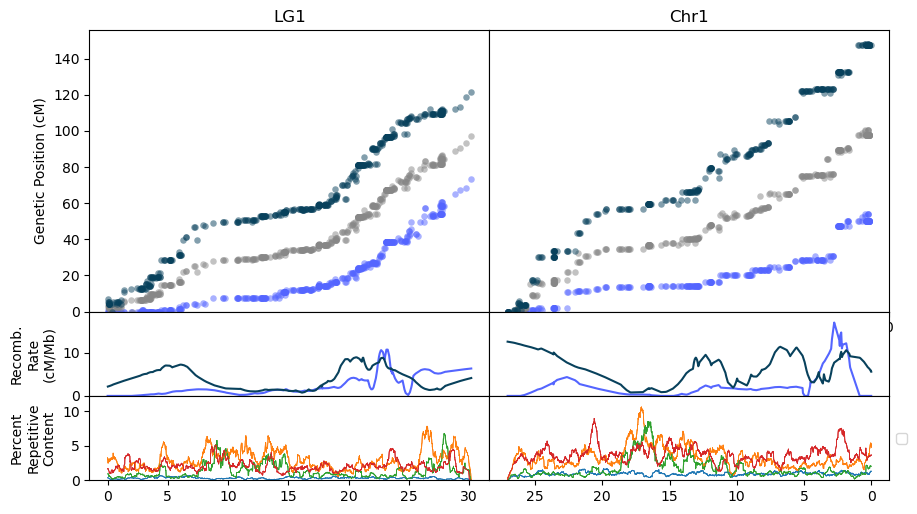

<Figure size 640x480 with 0 Axes>

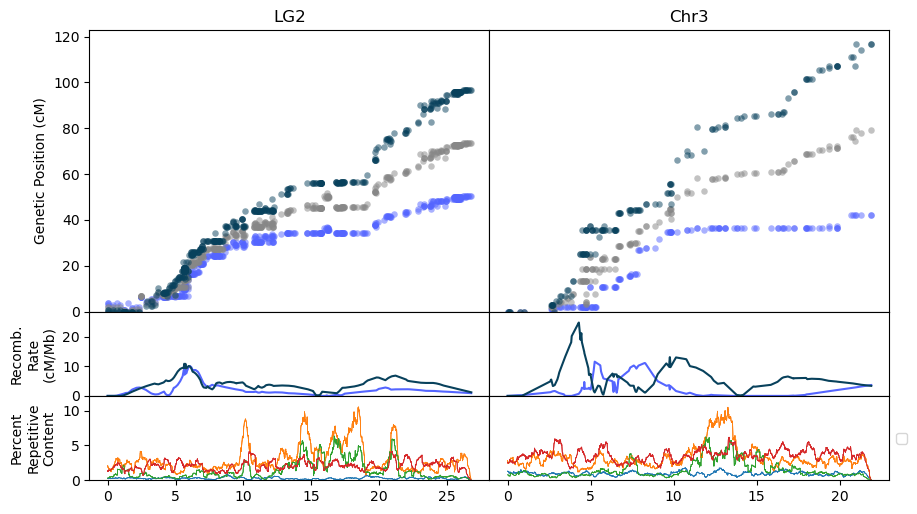

<Figure size 640x480 with 0 Axes>

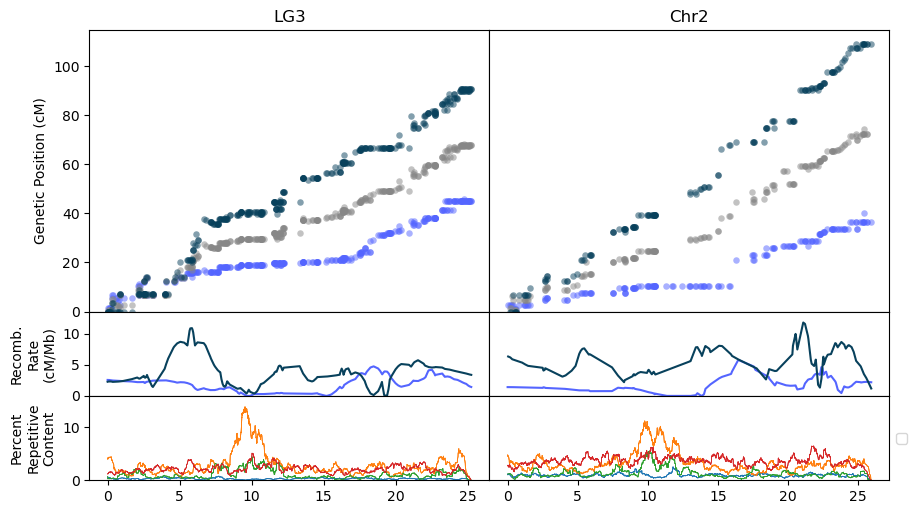

<Figure size 640x480 with 0 Axes>

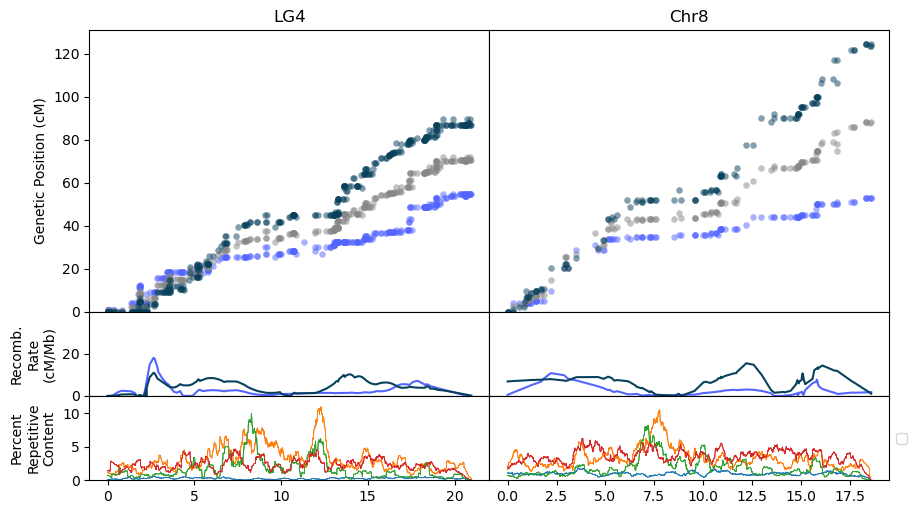

<Figure size 640x480 with 0 Axes>

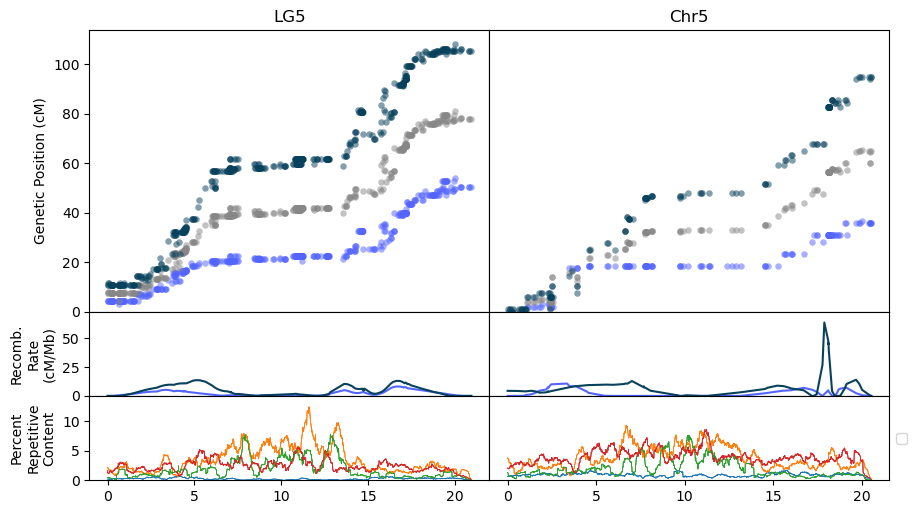

<Figure size 640x480 with 0 Axes>

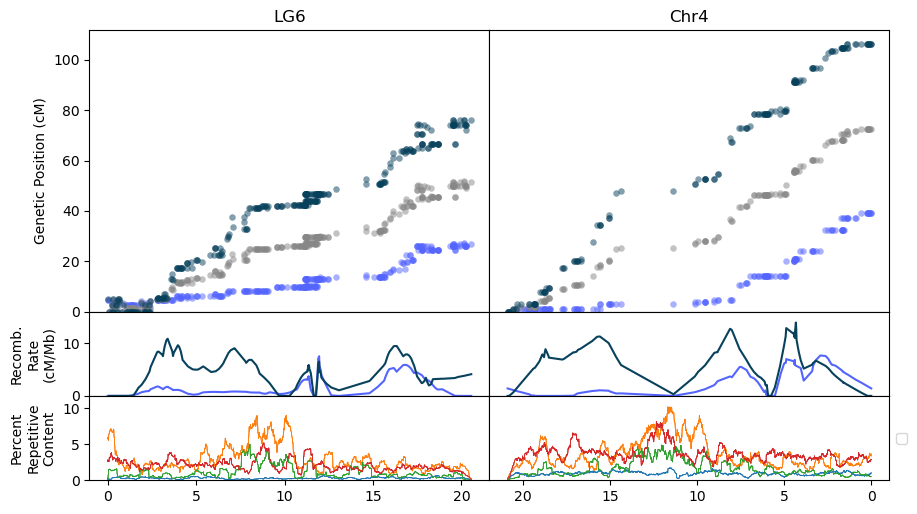

<Figure size 640x480 with 0 Axes>

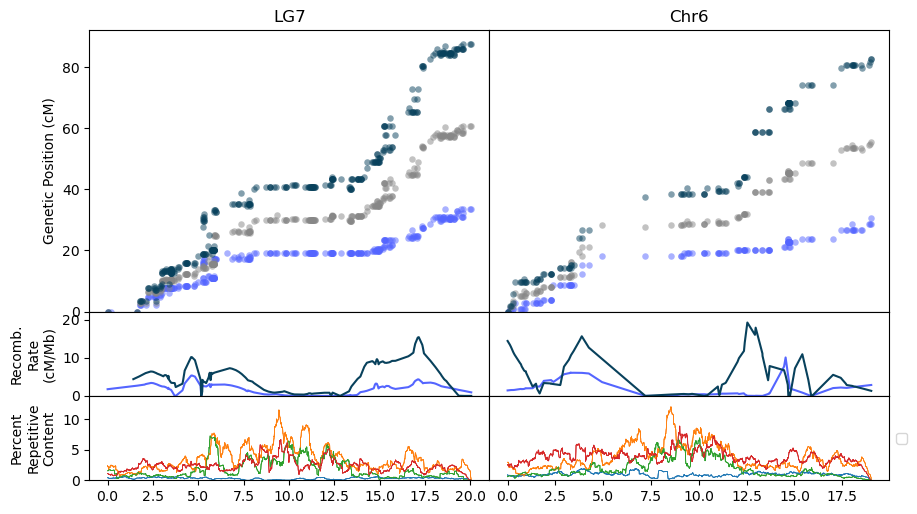

<Figure size 640x480 with 0 Axes>

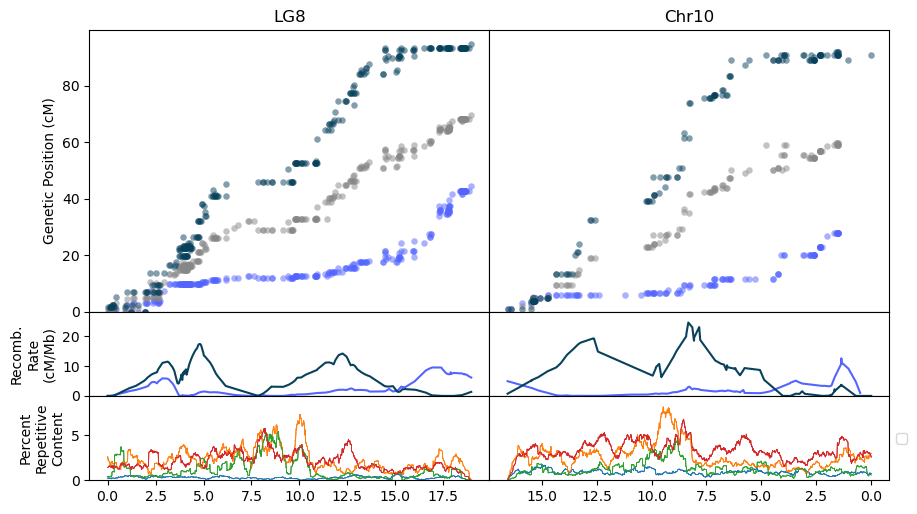

<Figure size 640x480 with 0 Axes>

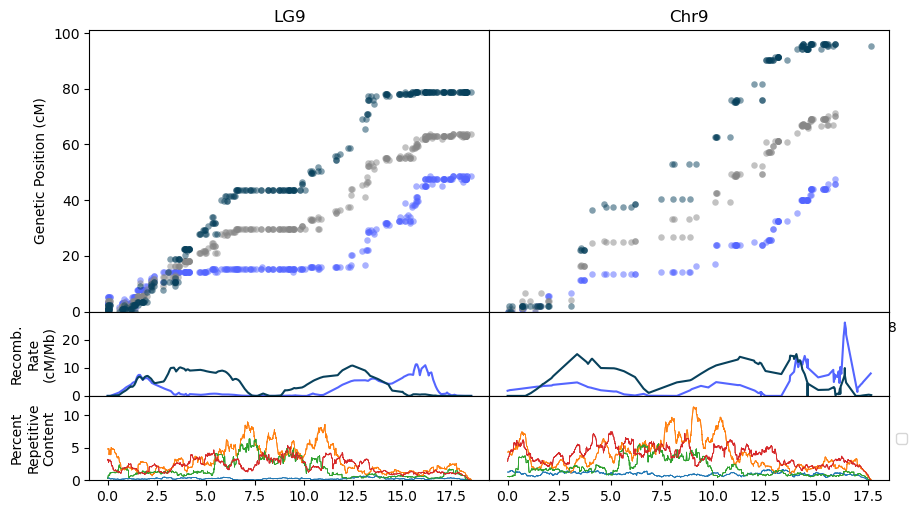

<Figure size 640x480 with 0 Axes>

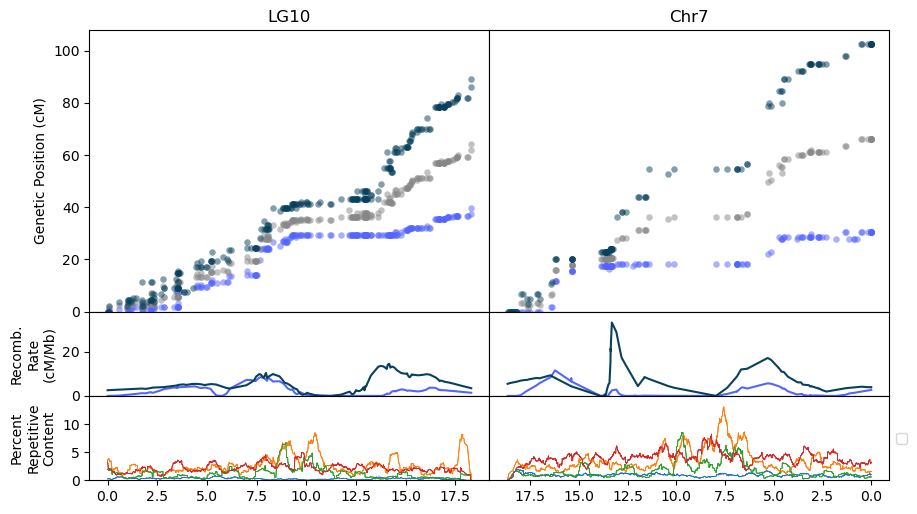

<Figure size 640x480 with 0 Axes>

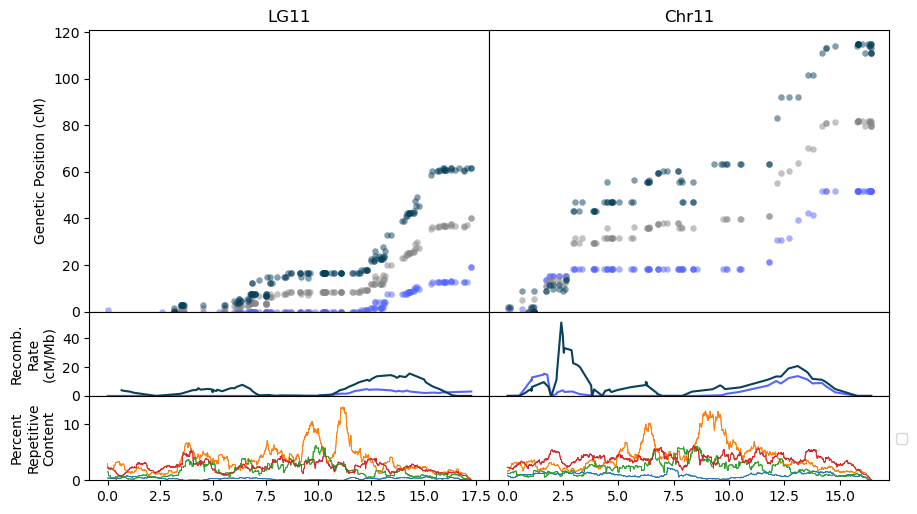

<Figure size 640x480 with 0 Axes>

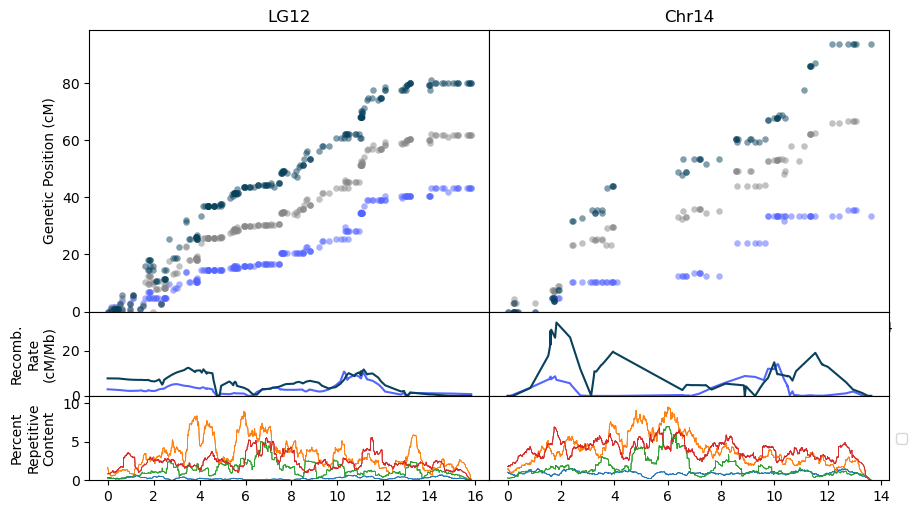

<Figure size 640x480 with 0 Axes>

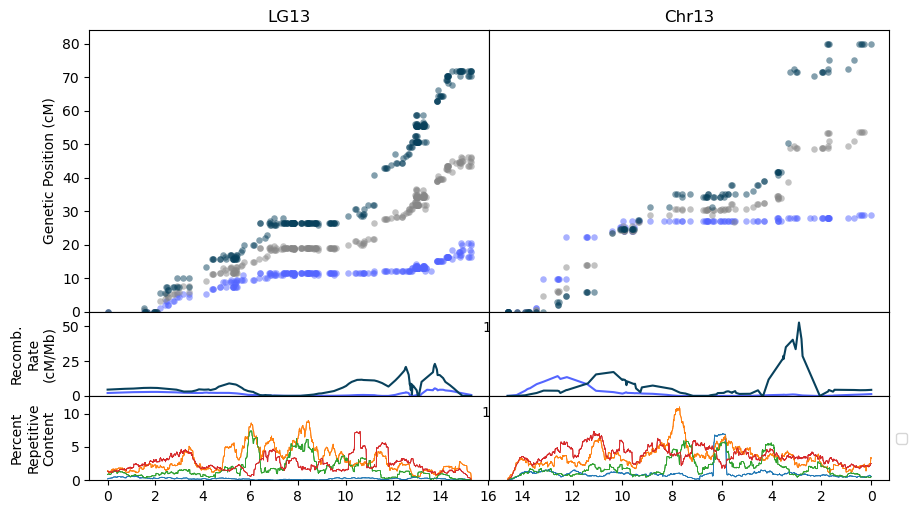

<Figure size 640x480 with 0 Axes>

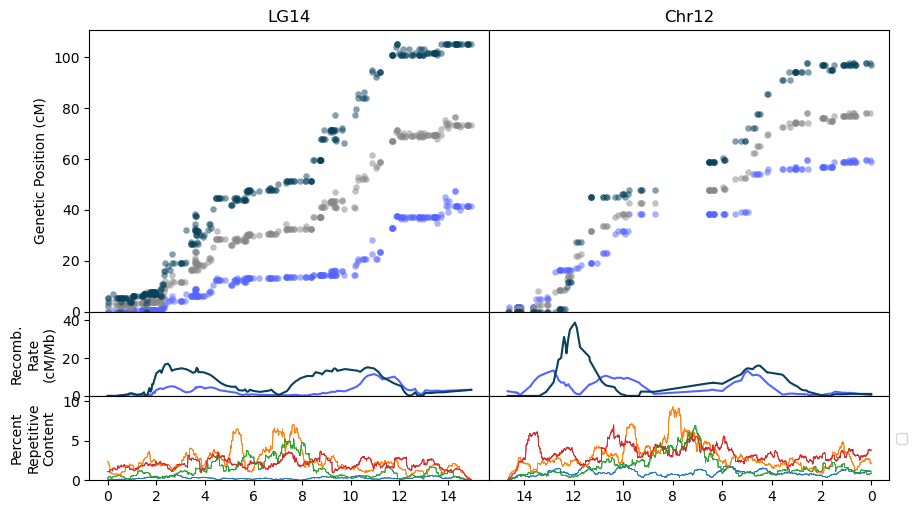

In [275]:
for chrs in list(homologouschr.keys()):
#for chrs in ["hic_scaffold_4"]:
    plt.figure()
    nrow = 3
    ncol = 2

    fig = plt.figure(figsize=(12, 6)) 

    gs = gridspec.GridSpec(nrow, ncol,
             wspace=0, hspace=0.0, 
             top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1), 
             left=0.5/(ncol+1), right=1-0.5/(ncol+1), 
             height_ratios = [5,1.5, 1.5]) 

    ax1 = plt.subplot(gs[0,0])
    ax2 = plt.subplot(gs[1,0])
    ax3 = plt.subplot(gs[2,0])
    ax4 = plt.subplot(gs[0,1])
    ax5 = plt.subplot(gs[1,1])
    ax6 = plt.subplot(gs[2,1])
    
    maxrepeat = []
    maxrecomb = []
    maxgendist = []
    for sex in ["MALE", "SEXAVG", "FEMALE"]:
        tmp = pd.read_csv("../recAllRatesLoess_Acroporacervicornis_" + sex + "_2023-12-14.txt", sep = " ")
        tmp = tmp[tmp["vld"] == True]
        tmp = tmp[tmp["map"] == homologouschr[chrs]].reset_index(drop=True)
        tmp["Mb"] = tmp["phys"] / 1000000
        tmp.loc[tmp["recombinationRate"] < 0, "recombinationRate"] = 0
        if tmp["gen"][0] > tmp["gen"][len(tmp) - 1]:
            tmp["recombinationRate"] = tmp["recombinationRate"] * -1
        if sex == "MALE":
            sns.scatterplot(data = tmp, x = "Mb", y = "gen", color = "#5465FF", ax=ax1, s = 22, 
                            edgecolor = None, linewidth=0, alpha = 0.5)
            sns.lineplot(data = tmp, x = "Mb", y = "recombinationRate", color = "#5465FF", ax=ax2)
        elif sex == "SEXAVG":
            sns.scatterplot(data = tmp, x = "Mb", y = "gen", color = "#878787", ax=ax1, s = 22, 
                            edgecolor = None, linewidth=0, alpha = 0.5)
        elif sex == "FEMALE":
            sns.scatterplot(data = tmp, x = "Mb", y = "gen", color = "#08415C", ax=ax1, s = 22, 
                            edgecolor = None, linewidth=0, alpha = 0.5)
            sns.lineplot(data = tmp, x = "Mb", y = "recombinationRate", color = "#08415C", ax = ax2)
        homolog1 = sns.lineplot(data = ac_repeats[ac_repeats[0] == homologouschr[chrs]], 
                            x = "Mb", y = "perc", lw = 0.5, alpha = 1.0, hue = "type", 
                            ax=ax3, legend = False)
        maxrepeat = maxrepeat + [ac_repeats["perc"][ac_repeats[0] == homologouschr[chrs]].max()]
        maxrecomb = maxrecomb + [tmp["recombinationRate"].max()]
        maxgendist = maxrecomb + [tmp["gen"].max()]
    for sex in ["MALE", "SEXAVG", "FEMALE"]:
        tmp = pd.read_csv("../recAllRatesLoess_Acroporapalmata_" + sex + "_2023-12-14.txt", sep = " ")
        tmp = tmp[tmp["vld"] == True]
        tmp = tmp[tmp["map"] == chrs].reset_index(drop=True)
        tmp["Mb"] = tmp["phys"] / 1000000
        if chrs not in reversed_chr:
            if tmp["gen"][0] > tmp["gen"][len(tmp) - 1]:
                tmp["recombinationRate"] = tmp["recombinationRate"] * -1
                tmp["gen"] = abs(tmp["gen"] - tmp["gen"].max())
        else:
            if tmp["gen"][0] > tmp["gen"][len(tmp) - 1]:
                tmp["recombinationRate"] = tmp["recombinationRate"] * -1
        tmp.loc[tmp["recombinationRate"] < 0, "recombinationRate"] = 0
        if sex == "MALE":
            apal = sns.scatterplot(data = tmp, x = "Mb", y = "gen", color = "#5465FF", ax=ax4, 
                                   s = 22, edgecolor = None, linewidth=0, alpha = 0.5)
            recomb = sns.lineplot(data = tmp, x = "Mb", y = "recombinationRate", color = "#5465FF", ax=ax5)
        elif sex == "SEXAVG":
            apal = sns.scatterplot(data = tmp, x = "Mb", y = "gen", color = "#878787", ax=ax4, s = 22, linewidth=0, 
                                   edgecolor = None, alpha = 0.5)
        elif sex == "FEMALE":
            apal = sns.scatterplot(data = tmp, x = "Mb", y = "gen", color = "#08415C", ax=ax4, s = 22, linewidth=0,
                                   edgecolor = None, alpha = 0.5)
            recomb = sns.lineplot(data = tmp, x = "Mb", y = "recombinationRate", color = "#08415C", ax = ax5)
        homolog1 = sns.lineplot(data = ap_repeats[ap_repeats[0] == chrs], 
                            x = "Mb", y = "perc", lw = 0.5, alpha = 1.0, hue = "type", 
                            ax=ax6, legend = False)
        maxrepeat = maxrepeat + [ap_repeats["perc"][ap_repeats[0] == chrs].max()]
        maxrecomb = maxrecomb + [tmp["recombinationRate"].max()]
        maxgendist = maxgendist + [tmp["gen"].max()]
        if chrs in reversed_chr:
            apal.invert_xaxis()
            recomb.invert_xaxis()
            homolog1.invert_xaxis()
        ax3.set_ylim([0, max(maxrepeat) + 
              ( max(maxrepeat) * 0.15)])
        ax6.set_ylim([0, max(maxrepeat) + 
              ( max(maxrepeat) * 0.15)])
        ax2.set_ylim([0, max(maxrecomb) + 
              ( max(maxrecomb) * 0.15)])
        ax5.set_ylim([0, max(maxrecomb) + 
              ( max(maxrecomb) * 0.15)])
        ax1.set_ylim([0, max(maxgendist) + 
              ( max(maxgendist) * 0.05)])
        ax4.set_ylim([0, max(maxgendist) + 
              ( max(maxgendist) * 0.05)])
    ax2.legend('',frameon=False)
    ax5.legend('',frameon=False)
    ax1.set_title(homologouschr[chrs])
    ax1.set_ylabel("Genetic Position (cM)")
    ax2.set_ylabel("Recomb.\nRate\n(cM/Mb)")
    ax3.set_ylabel("Percent\nRepetitive\nContent")
    ax4.set_title(apalrename[chrs])
    ax3.set_xlabel("")
    ax4.set_ylabel("")
    ax4.set_yticks([])
    ax5.set_ylabel("")
    ax5.set_yticks([])
    ax6.set_ylabel("")
    ax6.set_xlabel("")
    ax6.set_yticks([])
    ax6.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    legend_elements = [Line2D([0], [0], marker='o', color='w', label='Female',
                              markerfacecolor='#08415C', markersize=5),
                       Line2D([0], [0], marker='o', color='w', label='Sex Averaged',
                              markerfacecolor='#878787', markersize=5),
                       Line2D([0], [0], marker='o', color='w', label='Male',
                              markerfacecolor='#5465FF', markersize=5)]

    #ax6.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.savefig("../figures/chr_" + chrs + "_mareymap.pdf", dpi = 300)

In [ ]:
apscaf30["female_recomb"] = np.nan
apscaf30["male_recomb"] = np.nan
for i in range(len(apscaf30)):
    try:
        apscaf30["male_recomb"][i + 1] = (apscaf30["smoothed_MALE_SHIFTED"][i + 1] - apscaf30["smoothed_MALE_SHIFTED"][i]) / (apscaf30["Mb"][i+1] - apscaf30["Mb"][i])
    except:
        pass
    try:
        apscaf30["female_recomb"][i + 1] = (apscaf30["smoothed_FEMALE_SHIFTED"][i + 1] - apscaf30["smoothed_FEMALE_SHIFTED"][i]) / (apscaf30["Mb"][i+1] - apscaf30["Mb"][i])
    except:
        pass
    
aclg8["female_recomb"] = np.nan
aclg8["male_recomb"] = np.nan
for i in range(len(aclg8)):
    try:
        aclg8["male_recomb"][i + 1] = abs(aclg8["smoothed_MALE_SHIFTED"][i + 1] - aclg8["smoothed_MALE_SHIFTED"][i]) / abs(aclg8["Mb"][i+1] - aclg8["Mb"][i])
    except:
        pass
    try:
        aclg8["female_recomb"][i + 1] = abs(aclg8["smoothed_FEMALE_SHIFTED"][i + 1] - aclg8["smoothed_FEMALE_SHIFTED"][i]) / abs(aclg8["Mb"][i+1] - aclg8["Mb"][i])
    except:
        pass

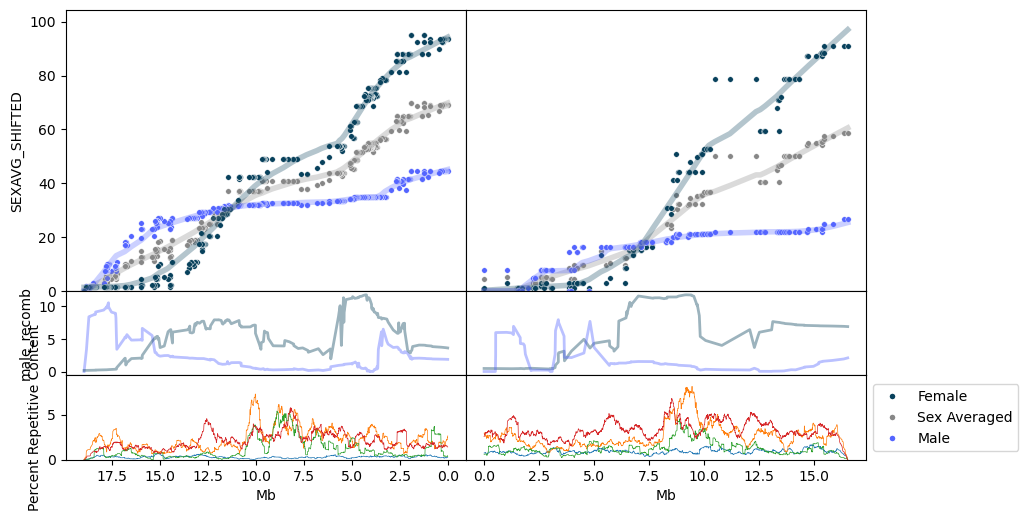

In [67]:
nrow = 3
ncol = 2

fig = plt.figure(figsize=(12, 6)) 

gs = gridspec.GridSpec(nrow, ncol,
         wspace=0, hspace=0.0, 
         top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1), 
         left=0.5/(ncol+1), right=1-0.5/(ncol+1), 
         height_ratios = [5,1.5, 1.5]) 

ax1 = plt.subplot(gs[0,0])
homolog1 = sns.scatterplot(data = aclg8, x = "Mb", y = "SEXAVG_SHIFTED", s=16, 
                        color = "#878787", ax=ax1)
homolog1 = sns.lineplot(data = aclg8, x = "Mb", y = "smoothed_SEXAVG_SHIFTED", alpha = 0.3, 
                     lw = 4, color = "#878787", ax=ax1)
# The sexes of the gametes are switched in Apal so we're just going to switch
# the color maps so they match Acer
homolog1 = sns.scatterplot(data = aclg8, x = "Mb", y = "MALE_SHIFTED", s=16, 
                        color = "#5465FF", ax=ax1)
homolog1 = sns.lineplot(data = aclg8, x = "Mb", y = "smoothed_MALE_SHIFTED", alpha = 0.3, 
                     lw = 4, color = "#5465FF", ax=ax1)
homolog1 = sns.scatterplot(data = aclg8, x = "Mb", y = "FEMALE_SHIFTED", s=16, 
                        color = "#08415C", ax=ax1)
homolog1 = sns.lineplot(data = aclg8, x = "Mb", y = "smoothed_FEMALE_SHIFTED", alpha = 0.3, 
                     lw = 4, color = "#08415C", ax=ax1)
maxcmval = np.max([apscaf30["MALE"].max(), aclg8["FEMALE"].max()])
ax1.set_ylim([0, maxcmval + (maxcmval * 0.1)])
homolog1.invert_xaxis()

ax2 = plt.subplot(gs[1,0])
recomb = sns.lineplot(data = aclg8, x = "Mb", y = "male_recomb", ax=ax2, color = "#5465FF", lw = 2, alpha = 0.4)
recomb = sns.lineplot(data = aclg8, x = "Mb", y = "female_recomb", ax=ax2, color = "#08415C", lw = 2, alpha = 0.4)
plt.legend('',frameon=False)
recomb.invert_xaxis()

ax3 = plt.subplot(gs[2,0])
#homolog1 = sns.lineplot(data = apal_gene_density[apal_gene_density[0] == "hic_scaffold_30"], x = 1, y = 3, lw = 0.5, alpha = 0.6)
homolog1 = sns.lineplot(data = ac_repeats[ac_repeats[0] == "LG8"], 
                        x = "Mb", y = "perc", lw = 0.5, alpha = 1, hue = "type", ax=ax3)
maxval = np.max([ap_repeats["perc"][ap_repeats[0] == "hic_scaffold_30"].max(), 
                ac_repeats["perc"][ac_repeats[0] == "LG8"].max()])
ax3.set_ylim([0, maxval + 
              ( maxval * 0.15)])
plt.legend('',frameon=False)
ax3.set_ylabel("Percent Repetitive Content")
homolog1.invert_xaxis()


ax4 = plt.subplot(gs[0,1])
homolog1 = sns.scatterplot(data = apscaf30, x = "Mb", y = "SEXAVG_SHIFTED", s=16, 
                        color = "#878787", ax=ax4)
homolog1 = sns.lineplot(data = apscaf30, x = "Mb", y = "smoothed_SEXAVG_SHIFTED", alpha = 0.3, 
                     lw = 4, color = "#878787", ax=ax4)
homolog1 = sns.scatterplot(data = apscaf30, x = "Mb", y = "MALE_SHIFTED", s=16, 
                        color = "#08415C", ax=ax4)
homolog1 = sns.lineplot(data = apscaf30, x = "Mb", y = "smoothed_MALE_SHIFTED", alpha = 0.3, 
                     lw = 4, color = "#08415C", ax=ax4)
homolog1 = sns.scatterplot(data = apscaf30, x = "Mb", y = "FEMALE_SHIFTED", s=16, 
                        color = "#5465FF", ax=ax4)
homolog1 = sns.lineplot(data = apscaf30, x = "Mb", y = "smoothed_FEMALE_SHIFTED", alpha = 0.3, 
                     lw = 4, color = "#5465FF", ax=ax4)
ax4.set_ylim([0, 100])
ax4.set_ylabel("")
ax4.set_yticks([])
ax4.set_ylim([0, maxcmval + (maxcmval * 0.1)])

ax5 = plt.subplot(gs[1,1])
recomb = sns.lineplot(data = apscaf30, x = "Mb", y = "male_recomb", ax=ax5, color = "#08415C", lw = 2, alpha = 0.4)
recomb = sns.lineplot(data = apscaf30, x = "Mb", y = "female_recomb", ax=ax5, color = "#5465FF", lw = 2, alpha = 0.4)
plt.legend('',frameon=False)
ax5.set_ylabel("")
ax5.set_yticks([])

ax6 = plt.subplot(gs[2,1])
#homolog1 = sns.lineplot(data = apal_gene_density[apal_gene_density[0] == "hic_scaffold_30"], x = 1, y = 3, lw = 0.5, alpha = 0.6)
homolog1 = sns.lineplot(data = ap_repeats[ap_repeats[0] == "hic_scaffold_30"], 
                        x = "Mb", y = "perc", lw = 0.5, alpha = 1.0, hue = "type", 
                        ax=ax6)
ax6.set_ylim([0, maxval + 
              ( maxval * 0.15)])
plt.legend('',frameon=False)
ax6.set_ylabel("")
ax6.set_yticks([])
ax6.legend(loc='center left', bbox_to_anchor=(1, 0.5))

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Female',
                          markerfacecolor='#08415C', markersize=5),
                   Line2D([0], [0], marker='o', color='w', label='Sex Averaged',
                          markerfacecolor='#878787', markersize=5),
                   Line2D([0], [0], marker='o', color='w', label='Male',
                          markerfacecolor='#5465FF', markersize=5)]

ax6.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
# add manual symbols to auto legend
#plt.savefig("../figures/ap30_ac8_mareymap.pdf", dpi = 300)

In [86]:
apscaf10["female_recomb"] = np.nan
apscaf10["male_recomb"] = np.nan
for i in range(len(apscaf10)):
    try:
        apscaf10["male_recomb"][i + 1] = (apscaf10["smoothed_MALE_SHIFTED"][i + 1] - apscaf10["smoothed_MALE_SHIFTED"][i]) / (apscaf10["Mb"][i+1] - apscaf10["Mb"][i])
    except:
        pass
    try:
        apscaf10["female_recomb"][i + 1] = (apscaf10["smoothed_FEMALE_SHIFTED"][i + 1] - apscaf10["smoothed_FEMALE_SHIFTED"][i]) / (apscaf10["Mb"][i+1] - apscaf10["Mb"][i])
    except:
        pass
    
aclg3["female_recomb"] = np.nan
aclg3["male_recomb"] = np.nan
for i in range(len(aclg3)):
    try:
        aclg3["male_recomb"][i + 1] = abs(aclg3["smoothed_MALE"][i + 1] - aclg3["smoothed_MALE"][i]) / abs(aclg3["Mb"][i+1] - aclg3["Mb"][i])
    except:
        pass
    try:
        aclg3["female_recomb"][i + 1] = abs(aclg3["smoothed_FEMALE"][i + 1] - aclg3["smoothed_FEMALE"][i]) / abs(aclg3["Mb"][i+1] - aclg3["Mb"][i])
    except:
        pass

/tmp/ipykernel_2649801/2632042941.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apscaf10["male_recomb"][i + 1] = (apscaf10["smoothed_MALE_SHIFTED"][i + 1] - apscaf10["smoothed_MALE_SHIFTED"][i]) / (apscaf10["Mb"][i+1] - apscaf10["Mb"][i])
/tmp/ipykernel_2649801/2632042941.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apscaf10["female_recomb"][i + 1] = (apscaf10["smoothed_FEMALE_SHIFTED"][i + 1] - apscaf10["smoothed_FEMALE_SHIFTED"][i]) / (apscaf10["Mb"][i+1] - apscaf10["Mb"][i])
/tmp/ipykernel_2649801/2632042941.py:17: RuntimeWarning: invalid value encountered in double_scalars
  aclg3["male_recomb"][i + 1]

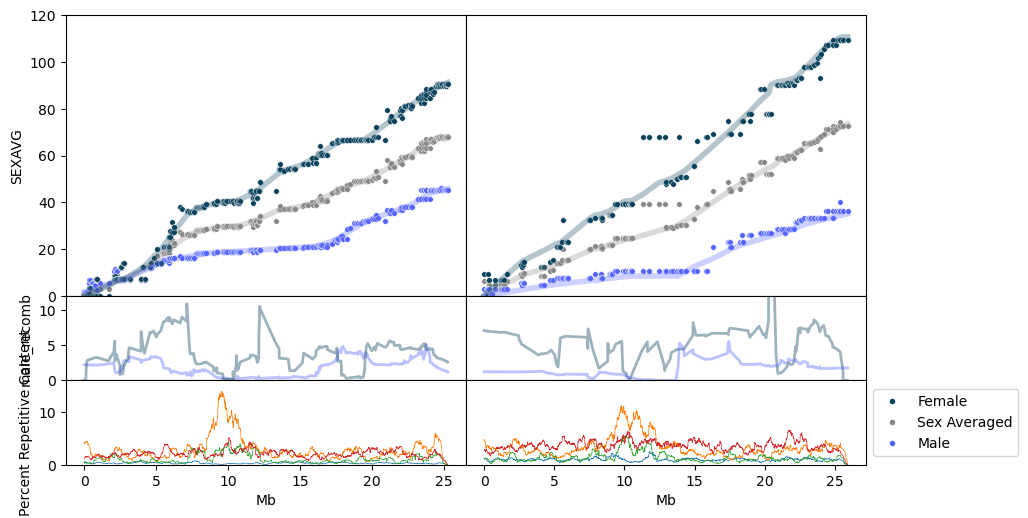

In [96]:
maxrecomb = np.max(        aclg3["male_recomb"][aclg3["male_recomb"].notna()].tolist() 
        + aclg3["female_recomb"][aclg3["female_recomb"].notna()].tolist())

nrow = 3
ncol = 2

fig = plt.figure(figsize=(12, 6)) 

gs = gridspec.GridSpec(nrow, ncol,
         wspace=0, hspace=0.0, 
         top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1), 
         left=0.5/(ncol+1), right=1-0.5/(ncol+1), 
         height_ratios = [5,1.5,1.5]) 

ax1 = plt.subplot(gs[0,0])
homolog1 = sns.scatterplot(data = aclg3, x = "Mb", y = "SEXAVG", s=16, 
                        color = "#878787", ax=ax1)
homolog1 = sns.lineplot(data = aclg3, x = "Mb", y = "smoothed_SEXAVG", alpha = 0.3, 
                     lw = 4, color = "#878787", ax=ax1)
# The sexes of the gametes are switched in Apal so we're just going to switch
# the color maps so they match Acer
homolog1 = sns.scatterplot(data = aclg3, x = "Mb", y = "MALE", s=16, 
                        color = "#5465FF", ax=ax1)
homolog1 = sns.lineplot(data = aclg3, x = "Mb", y = "smoothed_MALE", alpha = 0.3, 
                     lw = 4, color = "#5465FF", ax=ax1)
homolog1 = sns.scatterplot(data = aclg3, x = "Mb", y = "FEMALE", s=16, 
                        color = "#08415C", ax=ax1)
homolog1 = sns.lineplot(data = aclg3, x = "Mb", y = "smoothed_FEMALE", alpha = 0.3, 
                     lw = 4, color = "#08415C", ax=ax1)
maxcmval = np.max([apscaf10["MALE"].max(), aclg3["FEMALE"].max()])
ax1.set_ylim([0, maxcmval + (maxcmval * 0.1)])

ax2 = plt.subplot(gs[1,0])
recomb = sns.lineplot(data = aclg3, x = "Mb", y = "male_recomb", ax=ax2, color = "#5465FF", lw = 2, alpha = 0.4)
recomb = sns.lineplot(data = aclg3, x = "Mb", y = "female_recomb", ax=ax2, color = "#08415C", lw = 2, alpha = 0.4)
plt.legend('',frameon=False)
ax2.set_ylim([0, maxrecomb + (maxrecomb * 0.1)])

ax3 = plt.subplot(gs[2,0])
#homolog1 = sns.lineplot(data = apal_gene_density[apal_gene_density[0] == "hic_scaffold_10"], x = 1, y = 3, lw = 0.5, alpha = 0.6)
homolog1 = sns.lineplot(data = ac_repeats[ac_repeats[0] == "LG3"], 
                        x = "Mb", y = "perc", lw = 0.5, alpha = 1, hue = "type", ax=ax3)
maxval = np.max([ap_repeats["perc"][ap_repeats[0] == "hic_scaffold_10"].max(), 
                ac_repeats["perc"][ac_repeats[0] == "LG3"].max()])
ax3.set_ylim([0, maxval + 
              ( maxval * 0.15)])
plt.legend('',frameon=False)
ax3.set_ylabel("Percent Repetitive Content")

apscaf10["MALE_SHIFTED"] = abs(apscaf10["MALE"] - apscaf10["MALE"].max())
apscaf10["FEMALE_SHIFTED"] = abs(apscaf10["FEMALE"] - apscaf10["FEMALE"].max())
apscaf10["SEXAVG_SHIFTED"] = abs(apscaf10["SEXAVG"] - apscaf10["SEXAVG"].max())
apscaf10["smoothed_MALE_SHIFTED"] = abs(apscaf10["smoothed_MALE"] - apscaf10["smoothed_MALE"].max())
apscaf10["smoothed_FEMALE_SHIFTED"] = abs(apscaf10["smoothed_FEMALE"] - apscaf10["smoothed_FEMALE"].max())
apscaf10["smoothed_SEXAVG_SHIFTED"] = abs(apscaf10["smoothed_SEXAVG"] - apscaf10["smoothed_SEXAVG"].max())


ax4 = plt.subplot(gs[0,1])
homolog1 = sns.scatterplot(data = apscaf10, x = "Mb", y = "SEXAVG_SHIFTED", s=16, 
                        color = "#878787", ax=ax4)
homolog1 = sns.lineplot(data = apscaf10, x = "Mb", y = "smoothed_SEXAVG_SHIFTED", alpha = 0.3, 
                     lw = 4, color = "#878787", ax=ax4)
homolog1 = sns.scatterplot(data = apscaf10, x = "Mb", y = "MALE_SHIFTED", s=16, 
                        color = "#08415C", ax=ax4)
homolog1 = sns.lineplot(data = apscaf10, x = "Mb", y = "smoothed_MALE_SHIFTED", alpha = 0.3, 
                     lw = 4, color = "#08415C", ax=ax4)
homolog1 = sns.scatterplot(data = apscaf10, x = "Mb", y = "FEMALE_SHIFTED", s=16, 
                        color = "#5465FF", ax=ax4)
homolog1 = sns.lineplot(data = apscaf10, x = "Mb", y = "smoothed_FEMALE_SHIFTED", alpha = 0.3, 
                     lw = 4, color = "#5465FF", ax=ax4)
ax4.set_ylim([0, 100])
ax4.set_ylabel("")
ax4.set_yticks([])
ax4.set_ylim([0, maxcmval + (maxcmval * 0.1)])

ax5 = plt.subplot(gs[1,1])
recomb = sns.lineplot(data = apscaf10, x = "Mb", y = "male_recomb", ax=ax5, color = "#08415C", lw = 2, alpha = 0.4)
recomb = sns.lineplot(data = apscaf10, x = "Mb", y = "female_recomb", ax=ax5, color = "#5465FF", lw = 2, alpha = 0.4)
plt.legend('',frameon=False)
ax5.set_ylabel("")
ax5.set_yticks([])
ax5.set_ylim([0, maxrecomb + (maxrecomb * 0.1)])


ax6 = plt.subplot(gs[2,1])
#homolog1 = sns.lineplot(data = apal_gene_density[apal_gene_density[0] == "hic_scaffold_10"], x = 1, y = 3, lw = 0.5, alpha = 0.6)
homolog1 = sns.lineplot(data = ap_repeats[ap_repeats[0] == "hic_scaffold_10"], 
                        x = "Mb", y = "perc", lw = 0.5, alpha = 1.0, hue = "type", 
                        ax=ax6)
ax6.set_ylim([0, maxval + 
              ( maxval * 0.15)])
plt.legend('',frameon=False)
ax6.set_ylabel("")
ax6.set_yticks([])
ax6.legend(loc='center left', bbox_to_anchor=(1, 0.5))

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Female',
                          markerfacecolor='#08415C', markersize=5),
                   Line2D([0], [0], marker='o', color='w', label='Sex Averaged',
                          markerfacecolor='#878787', markersize=5),
                   Line2D([0], [0], marker='o', color='w', label='Male',
                          markerfacecolor='#5465FF', markersize=5)]

ax6.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
# add manual symbols to auto legend
#plt.savefig("../figures/ap10_ac3_mareymap.pdf", dpi = 300)

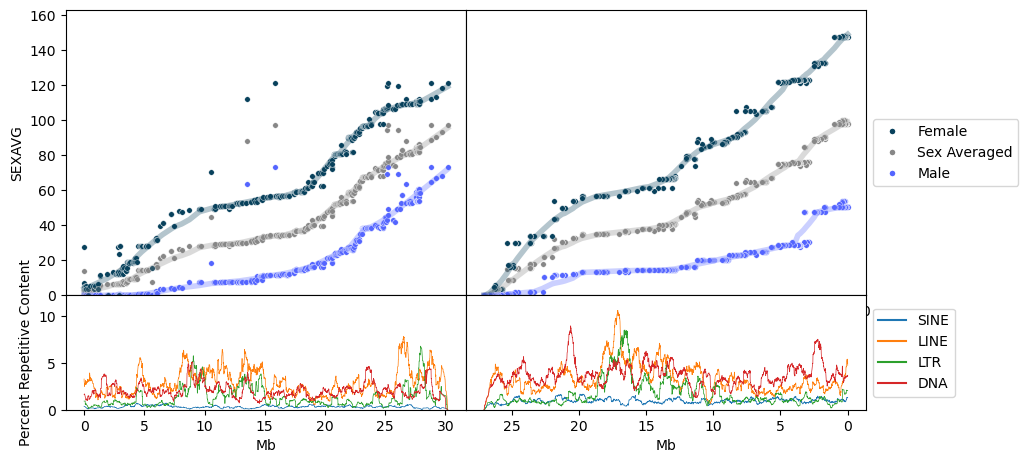

In [144]:
nrow = 2
ncol = 2

fig = plt.figure(figsize=(12, 6)) 

gs = gridspec.GridSpec(nrow, ncol,
         wspace=0, hspace=0.0, 
         top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1), 
         left=0.5/(ncol+1), right=1-0.5/(ncol+1), 
         height_ratios = [5,2]) 

ax1 = plt.subplot(gs[0,0])
homolog1 = sns.scatterplot(data = aclg1, x = "Mb", y = "SEXAVG", s=16, 
                        color = "#878787", ax=ax1)
homolog1 = sns.lineplot(data = aclg1, x = "Mb", y = "smoothed_SEXAVG", alpha = 0.3, 
                     lw = 4, color = "#878787", ax=ax1)
# The sexes of the gametes are switched in Apal so we're just going to switch
# the color maps so they match Acer
homolog1 = sns.scatterplot(data = aclg1, x = "Mb", y = "MALE", s=16, 
                        color = "#5465FF", ax=ax1)
homolog1 = sns.lineplot(data = aclg1, x = "Mb", y = "smoothed_MALE", alpha = 0.3, 
                     lw = 4, color = "#5465FF", ax=ax1)
homolog1 = sns.scatterplot(data = aclg1, x = "Mb", y = "FEMALE", s=16, 
                        color = "#08415C", ax=ax1)
homolog1 = sns.lineplot(data = aclg1, x = "Mb", y = "smoothed_FEMALE", alpha = 0.3, 
                     lw = 4, color = "#08415C", ax=ax1)
maxcmval = np.max([apscaf4["MALE"].max(), aclg1["FEMALE"].max()])
ax1.set_ylim([0, maxcmval + (maxcmval * 0.1)])


ax2 = plt.subplot(gs[1,0])
#homolog1 = sns.lineplot(data = apal_gene_density[apal_gene_density[0] == "hic_scaffold_30"], x = 1, y = 3, lw = 0.5, alpha = 0.6)
homolog1 = sns.lineplot(data = ac_repeats[ac_repeats[0] == "LG1"], 
                        x = "Mb", y = "perc", lw = 0.5, alpha = 1, hue = "type", ax=ax2)
maxval = np.max([ap_repeats["perc"][ap_repeats[0] == "hic_scaffold_4"].max(), 
                ac_repeats["perc"][ac_repeats[0] == "LG1"].max()])
ax2.set_ylim([0, maxval + 
              ( maxval * 0.15)])
plt.legend('',frameon=False)
ax2.set_ylabel("Percent Repetitive Content")


ax3 = plt.subplot(gs[0,1])
homolog1 = sns.scatterplot(data = apscaf4, x = "Mb", y = "SEXAVG", s=16, 
                        color = "#878787", ax=ax3)
homolog1 = sns.lineplot(data = apscaf4, x = "Mb", y = "smoothed_SEXAVG", alpha = 0.3, 
                     lw = 4, color = "#878787", ax=ax3)
homolog1 = sns.scatterplot(data = apscaf4, x = "Mb", y = "MALE", s=16, 
                        color = "#08415C", ax=ax3)
homolog1 = sns.lineplot(data = apscaf4, x = "Mb", y = "smoothed_MALE", alpha = 0.3, 
                     lw = 4, color = "#08415C", ax=ax3)
homolog1 = sns.scatterplot(data = apscaf4, x = "Mb", y = "FEMALE", s=16, 
                        color = "#5465FF", ax=ax3)
homolog1 = sns.lineplot(data = apscaf4, x = "Mb", y = "smoothed_FEMALE", alpha = 0.3, 
                     lw = 4, color = "#5465FF", ax=ax3)
homolog1.invert_xaxis()
ax3.set_ylim([0, 100])
ax3.set_ylabel("")
ax3.set_yticks([])
ax3.set_ylim([0, maxcmval + (maxcmval * 0.1)])


ax4 = plt.subplot(gs[1,1])
#homolog1 = sns.lineplot(data = apal_gene_density[apal_gene_density[0] == "hic_scaffold_30"], x = 1, y = 3, lw = 0.5, alpha = 0.6)
homolog1 = sns.lineplot(data = ap_repeats[ap_repeats[0] == "hic_scaffold_4"], 
                        x = "Mb", y = "perc", lw = 0.5, alpha = 1.0, hue = "type", 
                        ax=ax4)
homolog1.invert_xaxis()
ax4.set_ylim([0, maxval + 
              ( maxval * 0.15)])
plt.legend('',frameon=False)
ax4.set_ylabel("")
ax4.set_yticks([])
ax4.legend(loc='center left', bbox_to_anchor=(1, 0.5))

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Female',
                          markerfacecolor='#08415C', markersize=5),
                   Line2D([0], [0], marker='o', color='w', label='Sex Averaged',
                          markerfacecolor='#878787', markersize=5),
                   Line2D([0], [0], marker='o', color='w', label='Male',
                          markerfacecolor='#5465FF', markersize=5)]

ax3.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
# add manual symbols to auto legend
plt.savefig("../figures/ap4_ac1_mareymap.pdf", dpi = 300)

In [ ]:
dddd

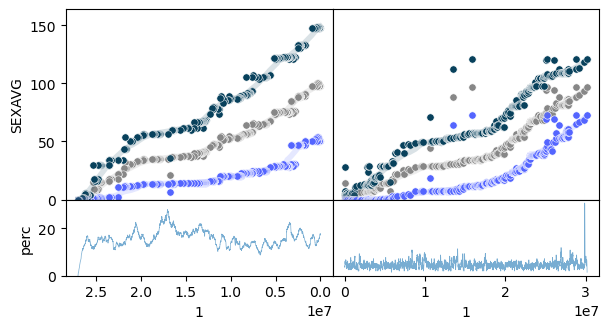

In [417]:
nrow = 2
ncol = 2

fig = plt.figure(figsize=(8, 4)) 

gs = gridspec.GridSpec(nrow, ncol,
         wspace=0, hspace=0.0, 
         top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1), 
         left=0.5/(ncol+1), right=1-0.5/(ncol+1), 
         height_ratios = [5,2]) 

ax1 = plt.subplot(gs[0,0])
homolog1 = sns.scatterplot(data = apscaf30, x = "Mb", y = "SEXAVG", s=10, 
                        color = "#878787", ax=ax1)
homolog1 = sns.lineplot(data = apscaf30, x = "Mb", y = "smoothed_SEXAVG", alpha = 0.15, 
                     lw = 4, color = "#878787", ax=ax1)
# The sexes of the gametes are switched in Apal so we're just going to switch
# the color maps so they match Acer
homolog1 = sns.scatterplot(data = apscaf30, x = "Mb", y = "FEMALE", s=10, 
                        color = "#5465FF", ax=ax1)
homolog1 = sns.lineplot(data = apscaf30, x = "Mb", y = "smoothed_FEMALE", alpha = 0.15, 
                     lw = 4, color = "#5465FF", ax=ax1)
homolog1 = sns.scatterplot(data = apscaf30, x = "Mb", y = "MALE", s=10, 
                        color = "#08415C", ax=ax1)
homolog1 = sns.lineplot(data = apscaf30, x = "Mb", y = "smoothed_MALE", alpha = 0.15, 
                     lw = 4, color = "#08415C", ax=ax1)
homolog1.invert_xaxis()
maxcmval = np.max([apscaf30["MALE"].max(), aclg8["FEMALE"].max()])
ax1.set_ylim([0, maxcmval + (maxcmval * 0.1)])


ax2 = plt.subplot(gs[1,0])
#homolog1 = sns.lineplot(data = apal_gene_density[apal_gene_density[0] == "hic_scaffold_30"], x = 1, y = 3, lw = 0.5, alpha = 0.6)
homolog1 = sns.lineplot(data = ap_repeats[ap_repeats[0] == "hic_scaffold_30"], 
                        x = "Mb", y = "perc", lw = 0.5, alpha = 1, hue = "type", ax=ax2)
homolog1.invert_xaxis()
maxval = np.max([ap_repeats["perc"][ap_repeats[0] == "hic_scaffold_30"].max(), 
                ac_repeats["perc"][ac_repeats[0] == "LG8"].max()])
ax2.set_ylim([0, maxval + 
              ( maxval * 0.15)])
plt.legend('',frameon=False)
ax2.set_ylabel("Percent Repetitive Content")


ax3 = plt.subplot(gs[0,1])
homolog1 = sns.scatterplot(data = aclg8, x = "Mb", y = "SEXAVG", s=10, 
                        color = "#878787", ax=ax3)
homolog1 = sns.lineplot(data = aclg8, x = "Mb", y = "smoothed_SEXAVG", alpha = 0.15, 
                     lw = 4, color = "#878787", ax=ax3)
homolog1 = sns.scatterplot(data = aclg8, x = "Mb", y = "FEMALE", s=10, 
                        color = "#08415C", ax=ax3)
homolog1 = sns.lineplot(data = aclg8, x = "Mb", y = "smoothed_FEMALE", alpha = 0.15, 
                     lw = 4, color = "#08415C", ax=ax3)
homolog1 = sns.scatterplot(data = aclg8, x = "Mb", y = "MALE", s=10, 
                        color = "#5465FF", ax=ax3)
homolog1 = sns.lineplot(data = aclg8, x = "Mb", y = "smoothed_MALE", alpha = 0.15, 
                     lw = 4, color = "#5465FF", ax=ax3)
ax3.set_ylim([0, 100])
ax3.set_ylabel("")
ax3.set_yticks([])
ax3.set_ylim([0, maxcmval + (maxcmval * 0.1)])


ax4 = plt.subplot(gs[1,1])
#homolog1 = sns.lineplot(data = apal_gene_density[apal_gene_density[0] == "hic_scaffold_30"], x = 1, y = 3, lw = 0.5, alpha = 0.6)
homolog1 = sns.lineplot(data = ac_repeats[ac_repeats[0] == "LG8"], 
                        x = "Mb", y = "perc", lw = 0.5, alpha = 1.0, hue = "type", ax=ax4)
ax4.set_ylim([0, maxval + 
              ( maxval * 0.15)])
plt.legend('',frameon=False)
ax4.set_ylabel("")
ax4.set_yticks([])
ax4.legend(loc='center left', bbox_to_anchor=(1, 0.5))

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Female',
                          markerfacecolor='#08415C', markersize=5),
                   Line2D([0], [0], marker='o', color='w', label='Sex Averaged',
                          markerfacecolor='#878787', markersize=5),
                   Line2D([0], [0], marker='o', color='w', label='Male',
                          markerfacecolor='#5465FF', markersize=5)]

ax3.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
# add manual symbols to auto legend

plt.show()

In [111]:
for parts in [2]:
    tmp = pd.read_csv("../../convert_snpchip_coords/lepwrap_apal/7_Distances/ordered." + str(parts) + ".distances", 
                sep = "\t", comment = "#", names =  ["Marker", "MALE", "FEMALE", 0, 1])
    sexavg = pd.read_csv("../../convert_snpchip_coords/lepwrap_apal/7_DistancesSexAverage/ordered." + str(parts) + ".sexavg", 
                sep = "\t", comment = "#", names =  ["Marker", "average", 0, 1, 2])
    sexavg = sexavg.merge(snps, how = "left", on = "Marker")
    tmp = tmp.merge(snps, how = "left", on = "Marker")
    tmp["LG"] = parts
    sexavg["LG"] = parts

In [21]:
sexavg["CHR"].value_counts()

Apal_hic_scaffold_30    142
Name: CHR, dtype: int64

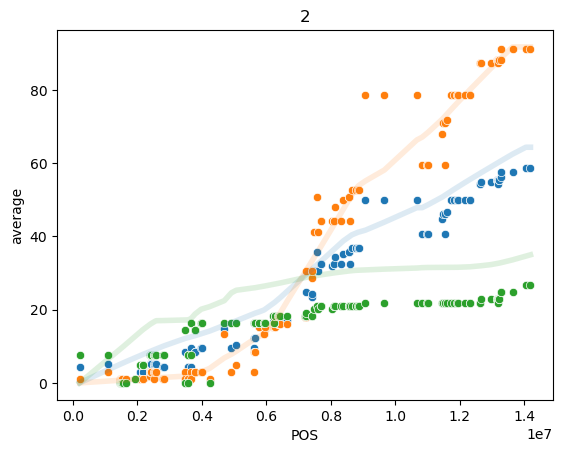

In [20]:
warnings.filterwarnings('ignore')
avgrecomb = []
link = pd.DataFrame()
for parts in [2]:
    tmp = pd.read_csv("../../convert_snpchip_coords/lepwrap_apal/7_Distances/ordered." + str(parts) + ".distances", 
                sep = "\t", comment = "#", names =  ["Marker", "MALE", "FEMALE", 0, 1])
    sexavg = pd.read_csv("../../convert_snpchip_coords/lepwrap_apal/7_DistancesSexAverage/ordered." + str(parts) + ".sexavg", 
                sep = "\t", comment = "#", names =  ["Marker", "average", 0, 1, 2])
    sexavg = sexavg.merge(snps, how = "left", on = "Marker")
    tmp = tmp.merge(snps, how = "left", on = "Marker")
    sexavg.loc[sexavg["CHR"] != sexavg.value_counts("CHR").reset_index()["CHR"][0], "delete"] = "yes"
    sexavg.loc[sexavg["CHR"] == sexavg.value_counts("CHR").reset_index()["CHR"][0], "delete"] = "no"
    sexavg = sexavg[sexavg["delete"] == "no"].reset_index(drop=True)
    sexavg["blank"] = "."
    sexavg = sexavg[["CHR", "blank", "average", "POS"]]
    sexavg["CHR"] = "Apal_" + sexavg["CHR"]
    #sexavg = sexavg.sort_values("average").reset_index(drop=True)
    #sexavg = sexavg.drop_duplicates("average").reset_index(drop=True)
    sexavg = sexavg.sort_values("POS").reset_index(drop=True)
    tmp.loc[tmp["CHR"] != tmp.value_counts("CHR").reset_index()["CHR"][0], "delete"] = "yes"
    tmp.loc[tmp["CHR"] == tmp.value_counts("CHR").reset_index()["CHR"][0], "delete"] = "no"
    tmp = tmp[tmp["delete"] == "no"].reset_index(drop=True)
    tmp["blank"] = "."
    tmp = tmp[["CHR", "FEMALE", "MALE", "POS"]]
    tmp["CHR"] = "Apal_" + tmp["CHR"]
    #tmp = tmp.sort_values("FEMALE").reset_index(drop=True)
    #tmp = tmp.drop_duplicates("FEMALE").reset_index(drop=True)
    tmp = tmp.sort_values("POS").reset_index(drop=True)
    start = 0.01
    while start < 1:
        smoothed = pd.DataFrame(sm.nonparametric.lowess(exog=sexavg["POS"], endog=sexavg["average"], frac = start))
        smoothed.columns = ["POS", "average"]
        if ( smoothed["POS"].is_monotonic or 
        smoothed["POS"].iloc[::-1].is_monotonic ) and ( smoothed["average"].is_monotonic or 
                                                  smoothed["average"].iloc[::-1].is_monotonic ):
            break
        else:
            start = start + 0.01
            smoothed = pd.DataFrame(sm.nonparametric.lowess(exog=sexavg["POS"], endog=sexavg["average"], frac = start))
            smoothed.columns = ["POS", "average"]
    smoothed = smoothed.sort_values("POS").reset_index(drop=True)
    smoothed.loc[smoothed["average"] < 0, "average"] = 0
    sexavg["smoothed"] = smoothed["average"]
    sexavg = sexavg.sort_values("POS").reset_index(drop=True)
    sexavg["lowess_smoothing_fraction"] = start
    start = 0.01
    while start < 1:
        smoothed = pd.DataFrame(sm.nonparametric.lowess(exog=tmp["POS"], endog=tmp["FEMALE"], frac = start))
        smoothed.columns = ["POS", "FEMALE"]
        if ( smoothed["POS"].is_monotonic or 
        smoothed["POS"].iloc[::-1].is_monotonic ) and ( smoothed["FEMALE"].is_monotonic or 
                                                  smoothed["FEMALE"].iloc[::-1].is_monotonic ):
            break
        else:
            start = start + 0.01
            smoothed = pd.DataFrame(sm.nonparametric.lowess(exog=tmp["POS"], endog=tmp["FEMALE"], frac = start))
            smoothed.columns = ["POS", "FEMALE"]
    smoothed = smoothed.sort_values("POS").reset_index(drop=True)
    smoothed.loc[smoothed["FEMALE"] < 0, "FEMALE"] = 0
    tmp["smoothed_FEMALE"] = smoothed["FEMALE"]
    tmp = tmp.sort_values("POS").reset_index(drop=True)
    tmp["lowess_smoothing_fraction_FEMALE"] = start
    start = 0.01
    while start < 1:
        smoothed = pd.DataFrame(sm.nonparametric.lowess(exog=tmp["POS"], endog=tmp["MALE"], frac = start))
        smoothed.columns = ["POS", "MALE"]
        if ( smoothed["POS"].is_monotonic or 
        smoothed["POS"].iloc[::-1].is_monotonic ) and ( smoothed["MALE"].is_monotonic or 
                                                  smoothed["MALE"].iloc[::-1].is_monotonic ):
            break
        else:
            start = start + 0.01
            smoothed = pd.DataFrame(sm.nonparametric.lowess(exog=tmp["POS"], endog=tmp["MALE"], frac = start))
            smoothed.columns = ["POS", "MALE"]
    smoothed = smoothed.sort_values("POS").reset_index(drop=True)
    smoothed.loc[smoothed["MALE"] < 0, "MALE"] = 0
    tmp["smoothed_MALE"] = smoothed["MALE"]
    tmp = tmp.sort_values("POS").reset_index(drop=True)
    tmp["lowess_smoothing_fraction_MALE"] = start
    if sexavg["smoothed"].is_monotonic:
        plt.figure()
        sns.scatterplot(x = sexavg["POS"], y = sexavg["average"])
        sns.lineplot(x = sexavg["POS"], y = sexavg["smoothed"], alpha = 0.15, lw = 4)
        sns.scatterplot(x = tmp["POS"], y = tmp["MALE"])
        sns.lineplot(x = tmp["POS"], y = tmp["smoothed_MALE"], alpha = 0.15, lw = 4)
        sns.scatterplot(x = tmp["POS"], y = tmp["FEMALE"])
        sns.lineplot(x = tmp["POS"], y = tmp["smoothed_FEMALE"], alpha = 0.15, lw = 4)
        plt.title(parts)
    else:
        sexavg["smoothed"] = np.abs(sexavg["smoothed"] - sexavg["smoothed"].max())
        sexavg["average"] = np.abs(sexavg["average"] - sexavg["average"].max())
        tmp["smoothed_MALE"] = np.abs(tmp["smoothed_MALE"] - tmp["smoothed_MALE"].max())
        tmp["MALE"] = np.abs(tmp["MALE"] - tmp["MALE"].max())
        tmp["smoothed_FEMALE"] = np.abs(tmp["smoothed_FEMALE"] - tmp["smoothed_FEMALE"].max())
        tmp["FEMALE"] = np.abs(tmp["FEMALE"] - tmp["FEMALE"].max())
        plt.figure()
        sns.scatterplot(x = sexavg["POS"], y = sexavg["average"])
        sns.lineplot(x = sexavg["POS"], y = sexavg["smoothed"], alpha = 0.15, lw = 4)
        sns.scatterplot(x = tmp["POS"], y = tmp["MALE"])
        sns.lineplot(x = tmp["POS"], y = tmp["smoothed_MALE"], alpha = 0.15, lw = 4)
        sns.scatterplot(x = tmp["POS"], y = tmp["FEMALE"])
        sns.lineplot(x = tmp["POS"], y = tmp["smoothed_FEMALE"], alpha = 0.15, lw = 4)
        plt.title(parts)
    link = pd.concat([link, sexavg])
    for i in list(range(len(sexavg))):
        try:
            avgrecomb = avgrecomb + [(( sexavg["smoothed"][i + 1] - sexavg["smoothed"][i] ) / (( sexavg["POS"][i + 1] - sexavg["POS"][i] )/1000000))]
        except:
            pass

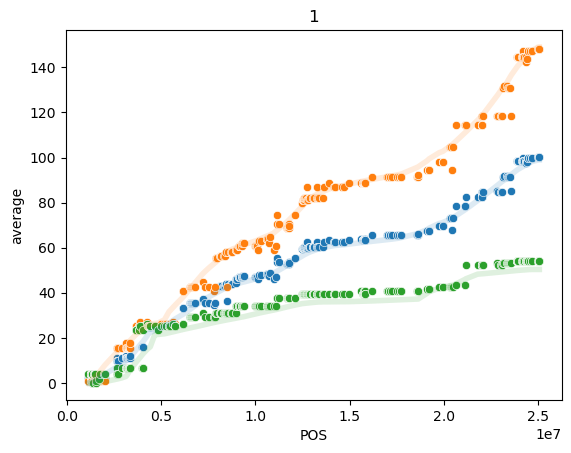

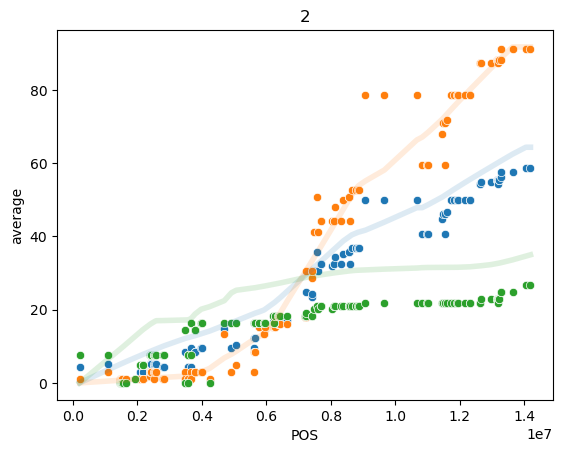

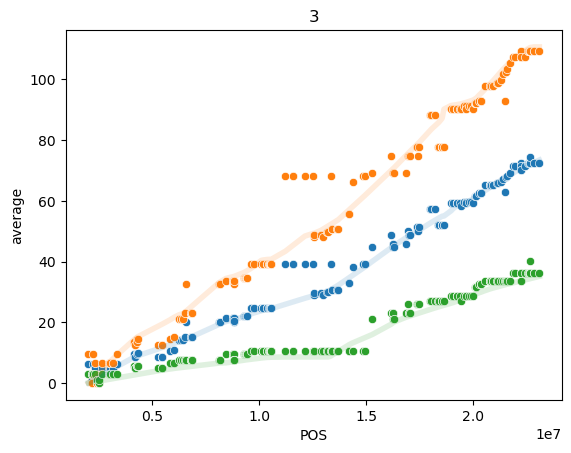

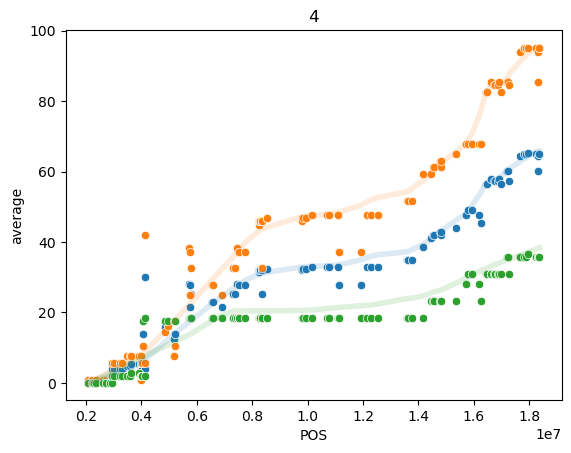

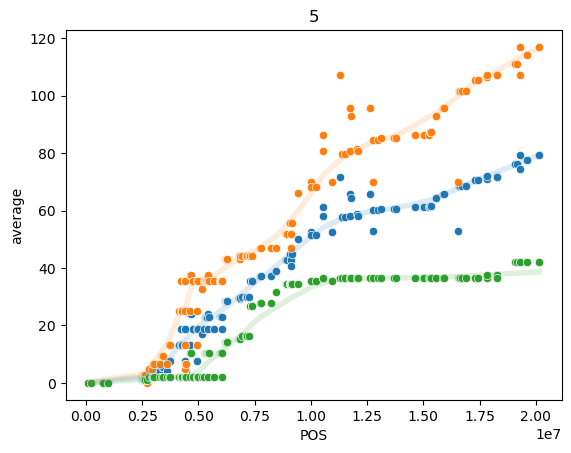

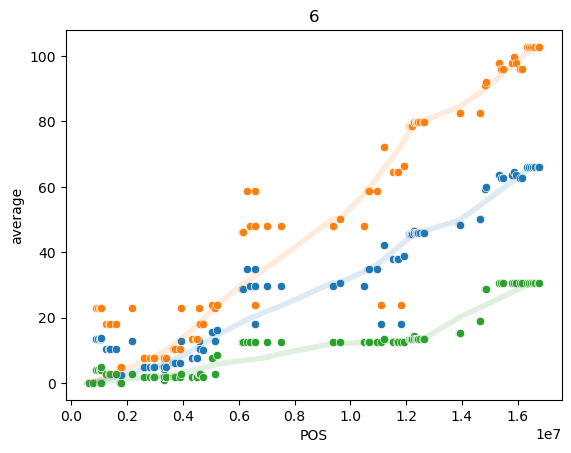

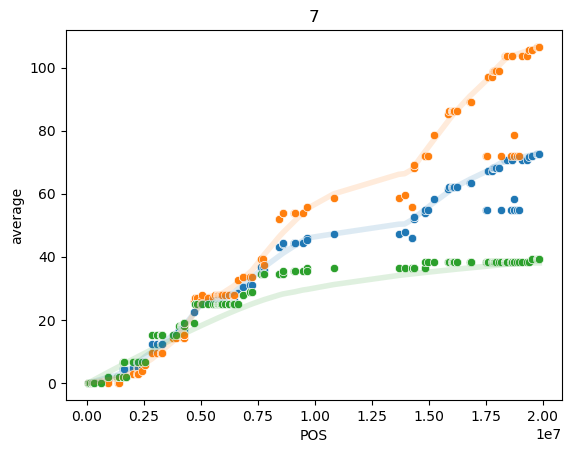

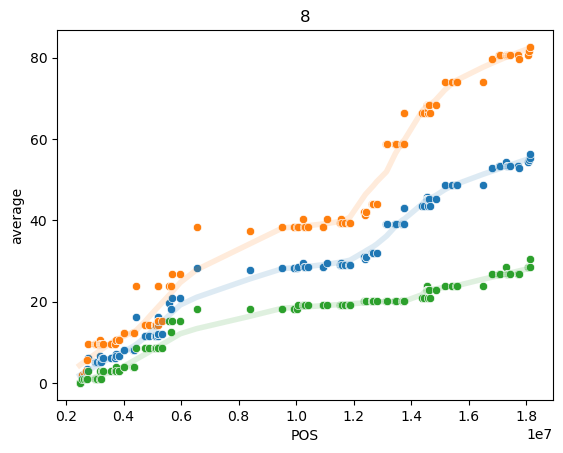

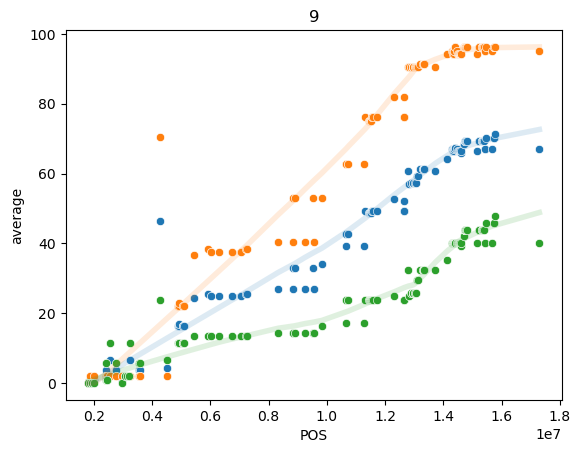

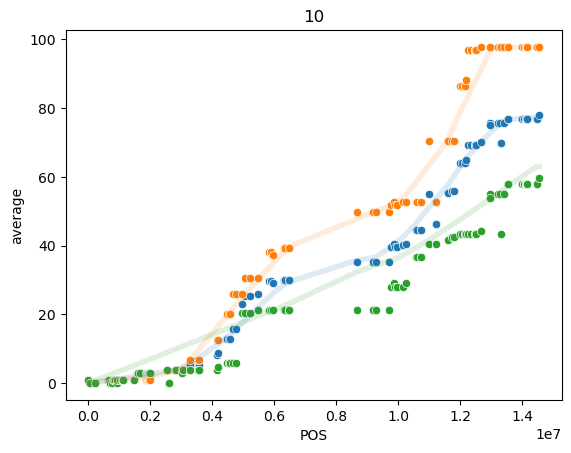

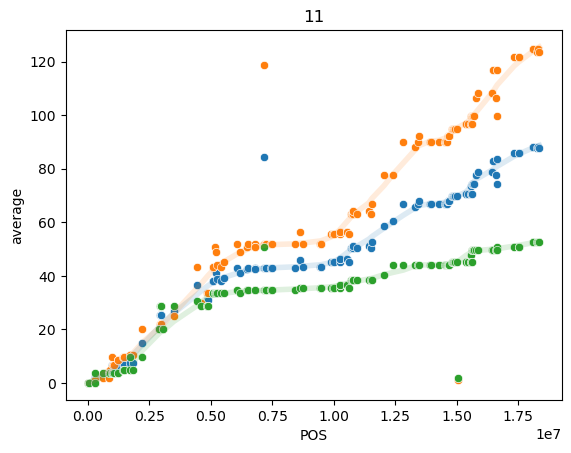

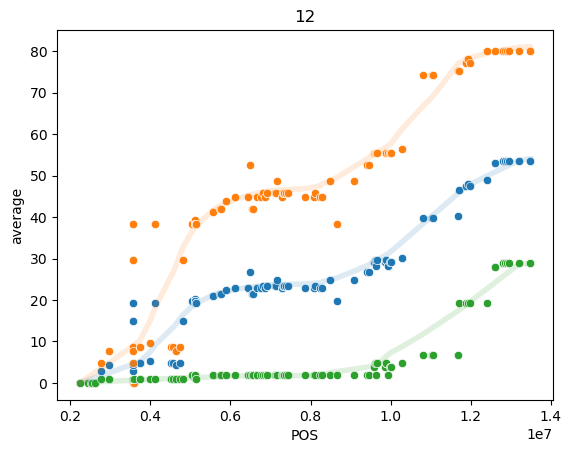

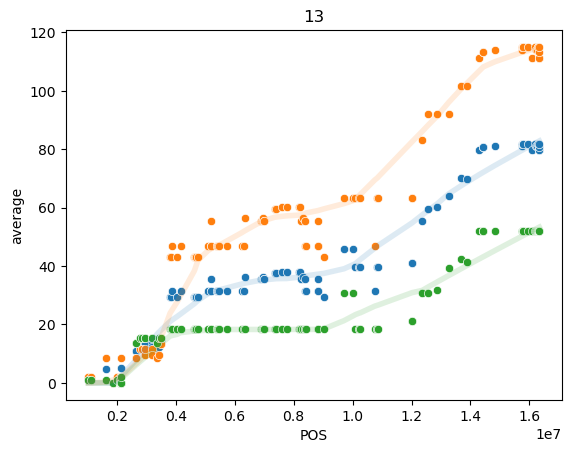

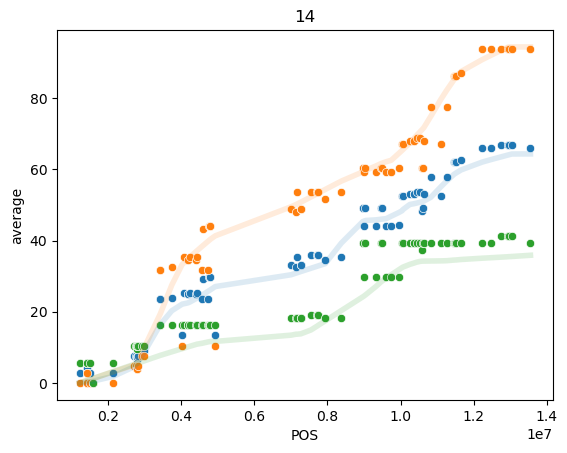

In [115]:
warnings.filterwarnings('ignore')
avgrecomb = []
link = pd.DataFrame()
for parts in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]:
    tmp = pd.read_csv("../../convert_snpchip_coords/lepwrap_apal/7_Distances/ordered." + str(parts) + ".distances", 
                sep = "\t", comment = "#", names =  ["Marker", "MALE", "FEMALE", 0, 1])
    sexavg = pd.read_csv("../../convert_snpchip_coords/lepwrap_apal/7_DistancesSexAverage/ordered." + str(parts) + ".sexavg", 
                sep = "\t", comment = "#", names =  ["Marker", "average", 0, 1, 2])
    sexavg = sexavg.merge(snps, how = "left", on = "Marker")
    tmp = tmp.merge(snps, how = "left", on = "Marker")
    sexavg.loc[sexavg["CHR"] != sexavg.value_counts("CHR").reset_index()["CHR"][0], "delete"] = "yes"
    sexavg.loc[sexavg["CHR"] == sexavg.value_counts("CHR").reset_index()["CHR"][0], "delete"] = "no"
    sexavg = sexavg[sexavg["delete"] == "no"].reset_index(drop=True)
    sexavg["blank"] = "."
    sexavg = sexavg[["CHR", "blank", "average", "POS"]]
    sexavg["CHR"] = "Apal_" + sexavg["CHR"]
    #sexavg = sexavg.sort_values("average").reset_index(drop=True)
    #sexavg = sexavg.drop_duplicates("average").reset_index(drop=True)
    sexavg = sexavg.sort_values("POS").reset_index(drop=True)
    tmp.loc[tmp["CHR"] != tmp.value_counts("CHR").reset_index()["CHR"][0], "delete"] = "yes"
    tmp.loc[tmp["CHR"] == tmp.value_counts("CHR").reset_index()["CHR"][0], "delete"] = "no"
    tmp = tmp[tmp["delete"] == "no"].reset_index(drop=True)
    tmp["blank"] = "."
    tmp = tmp[["CHR", "FEMALE", "MALE", "POS"]]
    tmp["CHR"] = "Apal_" + tmp["CHR"]
    #tmp = tmp.sort_values("FEMALE").reset_index(drop=True)
    #tmp = tmp.drop_duplicates("FEMALE").reset_index(drop=True)
    tmp = tmp.sort_values("POS").reset_index(drop=True)
    start = 0.01
    while start < 1:
        smoothed = pd.DataFrame(sm.nonparametric.lowess(exog=sexavg["POS"], endog=sexavg["average"], frac = start))
        smoothed.columns = ["POS", "average"]
        if ( smoothed["POS"].is_monotonic or 
        smoothed["POS"].iloc[::-1].is_monotonic ) and ( smoothed["average"].is_monotonic or 
                                                  smoothed["average"].iloc[::-1].is_monotonic ):
            break
        else:
            start = start + 0.01
            smoothed = pd.DataFrame(sm.nonparametric.lowess(exog=sexavg["POS"], endog=sexavg["average"], frac = start))
            smoothed.columns = ["POS", "average"]
    smoothed = smoothed.sort_values("POS").reset_index(drop=True)
    smoothed.loc[smoothed["average"] < 0, "average"] = 0
    sexavg["smoothed"] = smoothed["average"]
    sexavg = sexavg.sort_values("POS").reset_index(drop=True)
    sexavg["lowess_smoothing_fraction"] = start
    start = 0.01
    while start < 1:
        smoothed = pd.DataFrame(sm.nonparametric.lowess(exog=tmp["POS"], endog=tmp["FEMALE"], frac = start))
        smoothed.columns = ["POS", "FEMALE"]
        if ( smoothed["POS"].is_monotonic or 
        smoothed["POS"].iloc[::-1].is_monotonic ) and ( smoothed["FEMALE"].is_monotonic or 
                                                  smoothed["FEMALE"].iloc[::-1].is_monotonic ):
            break
        else:
            start = start + 0.01
            smoothed = pd.DataFrame(sm.nonparametric.lowess(exog=tmp["POS"], endog=tmp["FEMALE"], frac = start))
            smoothed.columns = ["POS", "FEMALE"]
    smoothed = smoothed.sort_values("POS").reset_index(drop=True)
    smoothed.loc[smoothed["FEMALE"] < 0, "FEMALE"] = 0
    tmp["smoothed_FEMALE"] = smoothed["FEMALE"]
    tmp = tmp.sort_values("POS").reset_index(drop=True)
    tmp["lowess_smoothing_fraction_FEMALE"] = start
    start = 0.01
    while start < 1:
        smoothed = pd.DataFrame(sm.nonparametric.lowess(exog=tmp["POS"], endog=tmp["MALE"], frac = start))
        smoothed.columns = ["POS", "MALE"]
        if ( smoothed["POS"].is_monotonic or 
        smoothed["POS"].iloc[::-1].is_monotonic ) and ( smoothed["MALE"].is_monotonic or 
                                                  smoothed["MALE"].iloc[::-1].is_monotonic ):
            break
        else:
            start = start + 0.01
            smoothed = pd.DataFrame(sm.nonparametric.lowess(exog=tmp["POS"], endog=tmp["MALE"], frac = start))
            smoothed.columns = ["POS", "MALE"]
    smoothed = smoothed.sort_values("POS").reset_index(drop=True)
    smoothed.loc[smoothed["MALE"] < 0, "MALE"] = 0
    tmp["smoothed_MALE"] = smoothed["MALE"]
    tmp = tmp.sort_values("POS").reset_index(drop=True)
    tmp["lowess_smoothing_fraction_MALE"] = start
    if sexavg["smoothed"].is_monotonic:
        plt.figure()
        sns.scatterplot(x = sexavg["POS"], y = sexavg["average"])
        sns.lineplot(x = sexavg["POS"], y = sexavg["smoothed"], alpha = 0.15, lw = 4)
        sns.scatterplot(x = tmp["POS"], y = tmp["MALE"])
        sns.lineplot(x = tmp["POS"], y = tmp["smoothed_MALE"], alpha = 0.15, lw = 4)
        sns.scatterplot(x = tmp["POS"], y = tmp["FEMALE"])
        sns.lineplot(x = tmp["POS"], y = tmp["smoothed_FEMALE"], alpha = 0.15, lw = 4)
        plt.title(parts)
    else:
        sexavg["smoothed"] = np.abs(sexavg["smoothed"] - sexavg["smoothed"].max())
        sexavg["average"] = np.abs(sexavg["average"] - sexavg["average"].max())
        tmp["smoothed_MALE"] = np.abs(tmp["smoothed_MALE"] - tmp["smoothed_MALE"].max())
        tmp["MALE"] = np.abs(tmp["MALE"] - tmp["MALE"].max())
        tmp["smoothed_FEMALE"] = np.abs(tmp["smoothed_FEMALE"] - tmp["smoothed_FEMALE"].max())
        tmp["FEMALE"] = np.abs(tmp["FEMALE"] - tmp["FEMALE"].max())
        plt.figure()
        sns.scatterplot(x = sexavg["POS"], y = sexavg["average"])
        sns.lineplot(x = sexavg["POS"], y = sexavg["smoothed"], alpha = 0.15, lw = 4)
        sns.scatterplot(x = tmp["POS"], y = tmp["MALE"])
        sns.lineplot(x = tmp["POS"], y = tmp["smoothed_MALE"], alpha = 0.15, lw = 4)
        sns.scatterplot(x = tmp["POS"], y = tmp["FEMALE"])
        sns.lineplot(x = tmp["POS"], y = tmp["smoothed_FEMALE"], alpha = 0.15, lw = 4)
        plt.title(parts)
    link = pd.concat([link, sexavg])
    for i in list(range(len(sexavg))):
        try:
            avgrecomb = avgrecomb + [(( sexavg["smoothed"][i + 1] - sexavg["smoothed"][i] ) / (( sexavg["POS"][i + 1] - sexavg["POS"][i] )/1000000))]
        except:
            pass

In [ ]:
!ls -lh /storage/group/ibb3/default/acer_cnat_dcyl_ssid_assembly/acer_linkage_scaffolding/lepwrap_denovo2/12_Fasta/Anchored.scaffolds.len_renamed_sorted.fa

In [7]:
%%bash
source ~/.bashrc
conda activate minimap2
cd /storage/group/ibb3/default/acer_cnat_dcyl_ssid_assembly/acer_linkage_scaffolding/

minimap2 -x asm5 -t 8 \
    ./lepwrap_denovo2/12_Fasta/Anchored.scaffolds.len_renamed_sorted.fa \
    /storage/group/ibb3/default/AP_AC_genome_seqs/dovetail_Apalm/HiC_improvement/Apalm_assembly_v3.1_200911.masked.fasta \
    > external.paf

[M::mm_idx_gen::5.447*1.65] collected minimizers
[M::mm_idx_gen::5.788*1.97] sorted minimizers
[M::main::5.788*1.97] loaded/built the index for 3308 target sequence(s)
[M::mm_mapopt_update::6.160*1.91] mid_occ = 88
[M::mm_idx_stat] kmer size: 19; skip: 19; is_hpc: 0; #seq: 3308
[M::mm_idx_stat::6.437*1.87] distinct minimizers: 23885820 (92.07% are singletons); average occurrences: 1.281; average spacing: 9.981; total length: 305412111
[M::worker_pipeline::33.262*5.37] mapped 406 sequences
[M::main] Version: 2.24-r1122
[M::main] CMD: minimap2 -x asm5 -t 8 ./lepwrap_denovo2/12_Fasta/Anchored.scaffolds.len_renamed_sorted.fa /storage/group/ibb3/default/AP_AC_genome_seqs/dovetail_Apalm/HiC_improvement/Apalm_assembly_v3.1_200911.masked.fasta
[M::main] Real time: 33.489 sec; CPU: 178.717 sec; Peak RSS: 5.572 GB


In [8]:
%%bash
source ~/.bashrc
conda activate assembly

cd /storage/group/ibb3/default/acer_cnat_dcyl_ssid_assembly/acer_linkage_scaffolding/
/storage/group/ibb3/default/acer_cnat_dcyl_ssid_assembly/synteny_scaffolding/dotPlotly/pafCoordsDotPlotly.R \
    -i external.paf -o out_ex -s -t -k 14 -l

PARAMETERS:
input (-i): external.paf
output (-o): out_ex
minimum query aggregate alignment length (-q): 4e+05
minimum alignment length (-m): 10000
plot size (-p): 15
show horizontal lines (-l): TRUE
number of reference chromosomes to keep (-k): 14
show % identity (-s): TRUE
show % identity for on-target alignments only (-t): TRUE
produce interactive plot (-x): TRUE
reference IDs to keep (-r): 

Number of alignments: 11685
Number of query sequences: 405

After filtering... Number of alignments: 662
After filtering... Number of query sequences: 20



Error in pandoc_self_contained_html(file, file) : 
  Saving a widget with selfcontained = TRUE requires pandoc. See here to learn more https://bookdown.org/yihui/rmarkdown-cookbook/install-pandoc.html
Calls: <Anonymous> -> pandoc_self_contained_html


No traceback available 


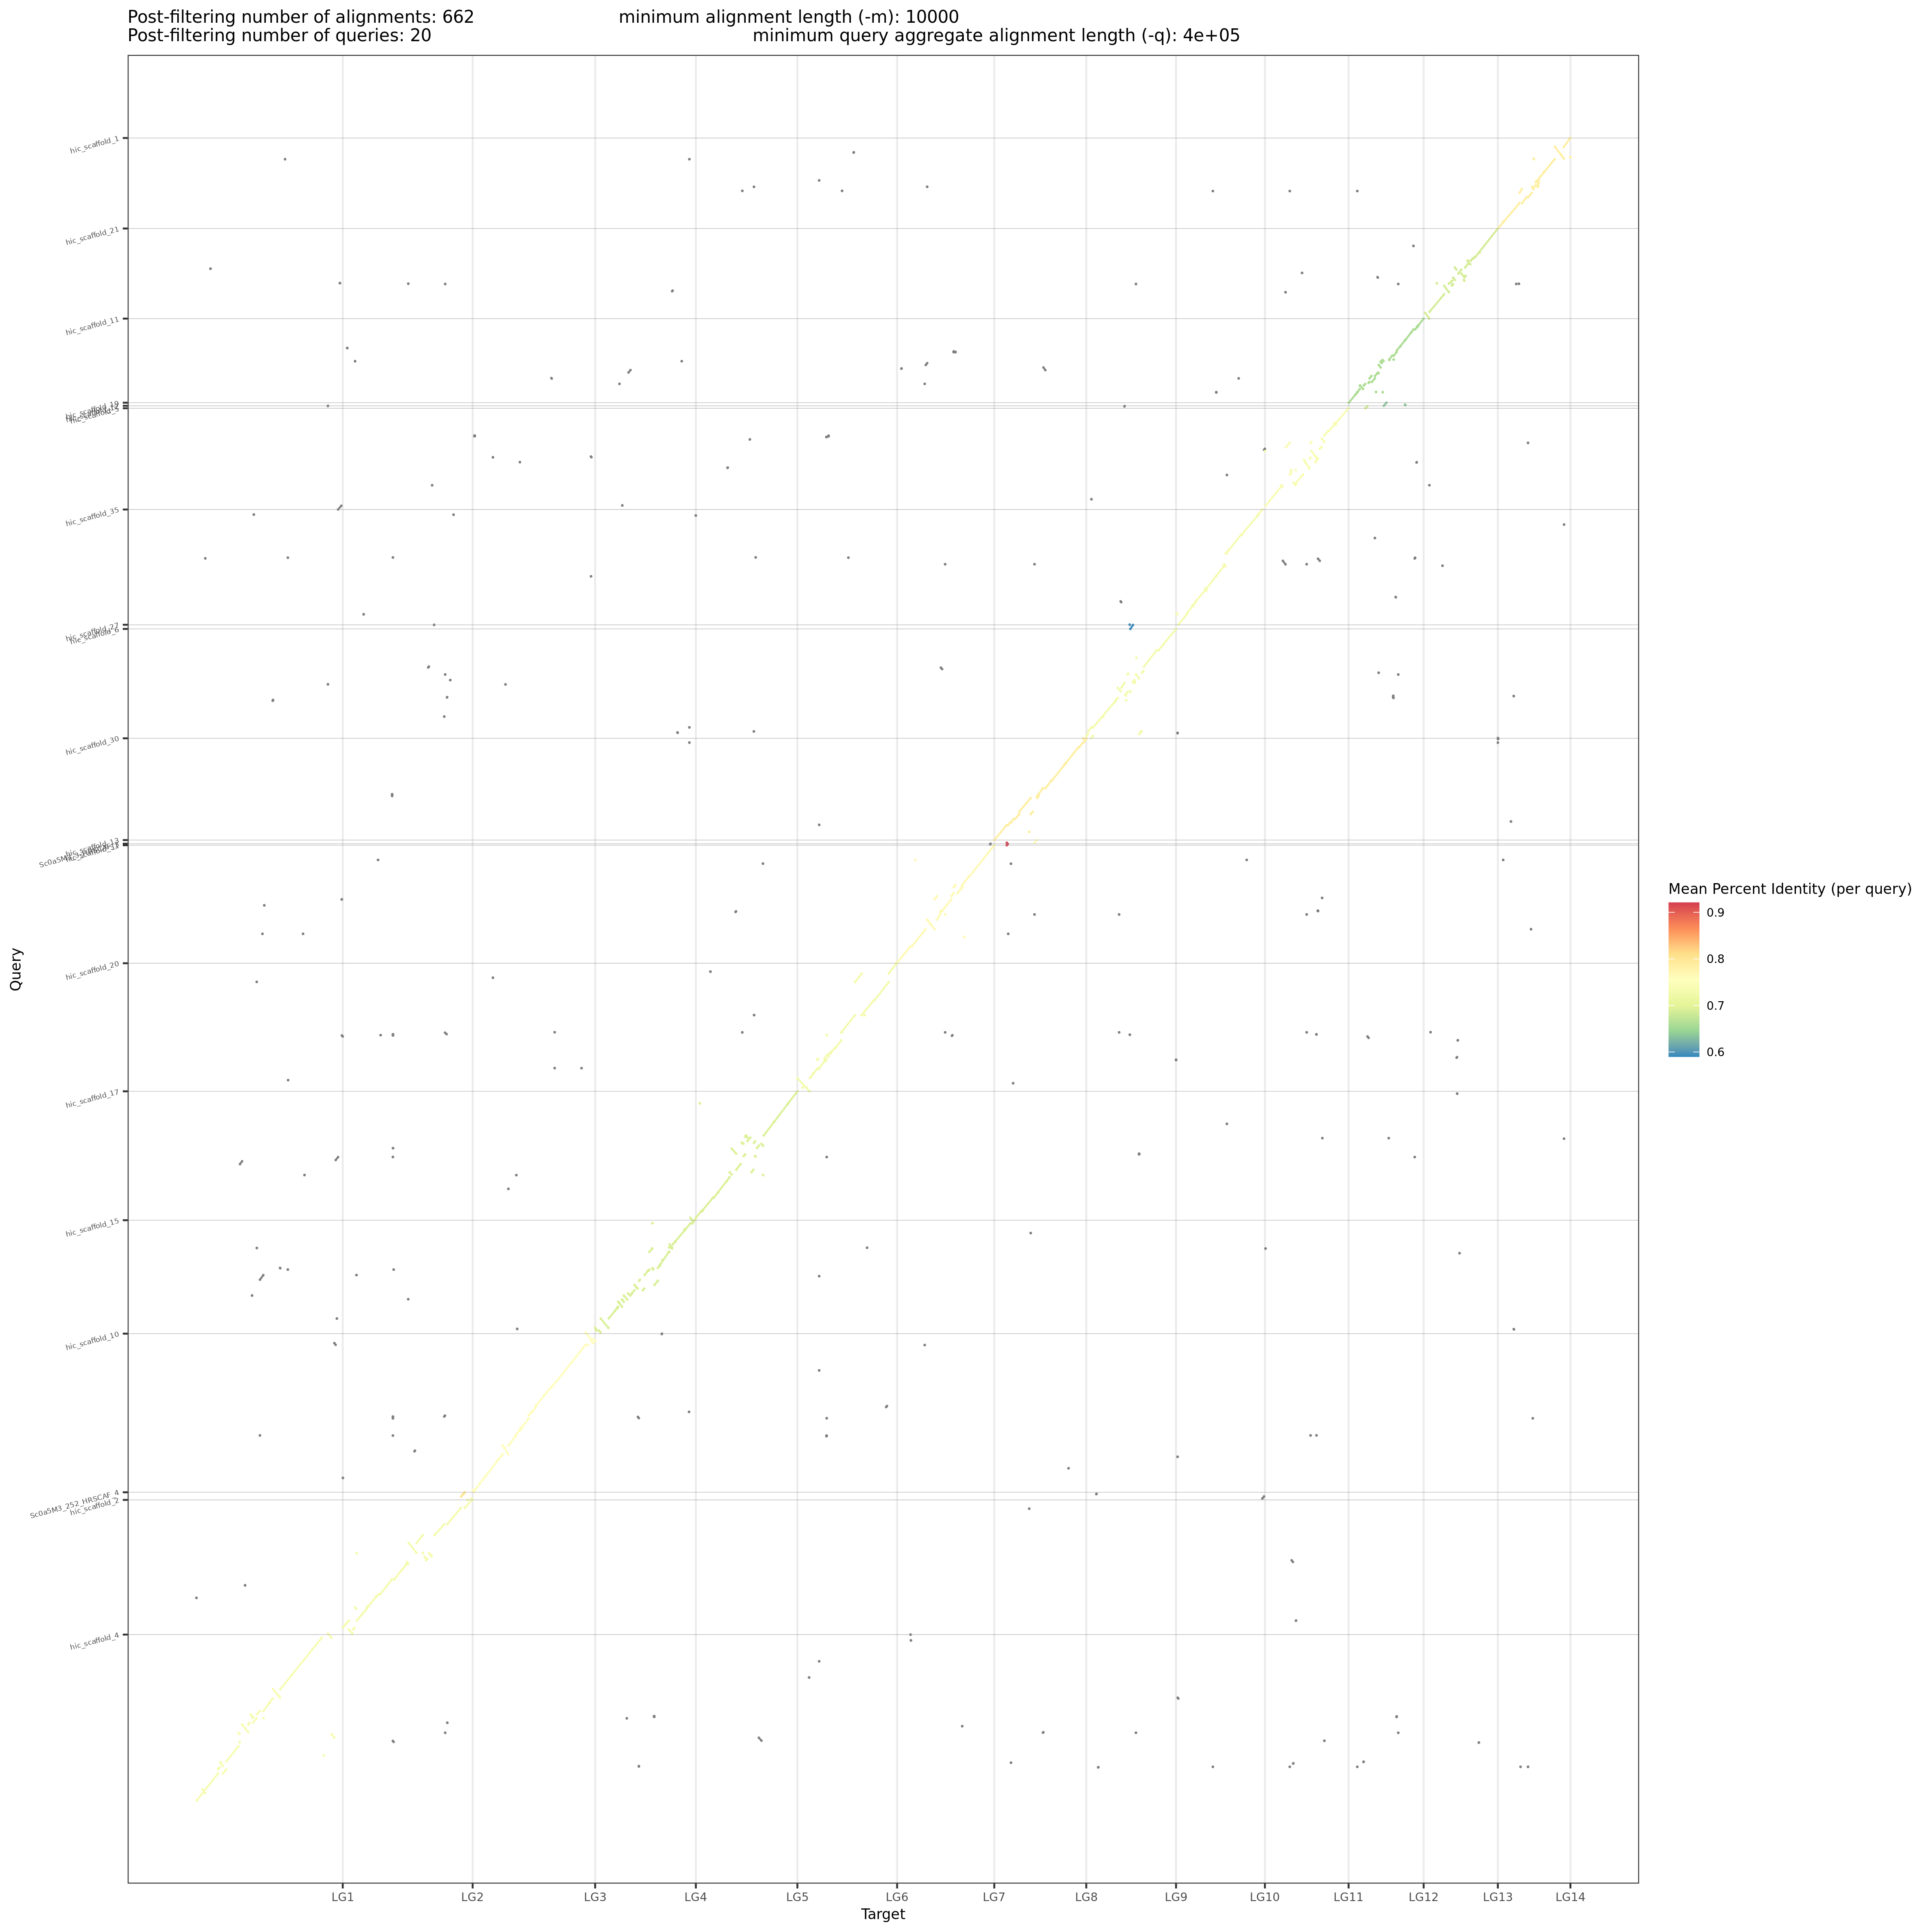

In [9]:
from IPython.display import Image
Image("/storage/group/ibb3/default/acer_cnat_dcyl_ssid_assembly/acer_linkage_scaffolding/out_ex.png")

In [2]:
from matplotlib import rcParams
import warnings
import statsmodels.api as sm

In [3]:
lg

CHR       POS  NA  NA1    MALE  FEMALE  average   smoothed  \
0    LG14     68678  14    1   0.685  18.447   9.5660   0.221975   
1    LG14    788115  14    1   4.110  23.931  14.0205   0.365679   
2    LG14   2599633  14    1   0.000   6.707   3.3535   0.836177   
3    LG14   3138677  14    1   0.000   0.000   0.0000   0.999425   
4    LG14   3149410  14    1   0.000   0.000   0.0000   1.002620   
..    ...       ...  ..  ...     ...     ...      ...        ...   
165  LG14  16590356  14    1  12.537  60.868  36.7025  39.629240   
166  LG14  16597069  14    1  12.537  60.133  36.3350  39.653352   
167  LG14  16729038  14    1  12.537  61.604  37.0705  40.121487   
168  LG14  16927768  14    1  19.067  61.604  40.3355  40.807581   
169  LG14  16943802  14    1  19.067  61.604  40.3355  40.862056   

     lowess_smoothing_fraction  smoothed_FEMALE  \
0                         0.22         0.000000   
1                         0.22         0.000000   
2                         0.22         0.875857   
3                         0.22         1.487934   
4                         0.22         1.500131   
..                         ...              ...   
165                       0.22        68.393507   
166                       0.22        68.460518   
167                       0.22        69.773978   
168                       0.22        71.738505   
169                       0.22        71.896344   

     lowess_smoothing_fraction_FEMALE  smoothed_MALE  \
0                                0.35       0.000000   
1                                0.35       0.000000   
2                                0.35       0.000000   
3                                0.35       0.000000   
4                                0.35       0.000000   
..                                ...            ...   
165                              0.35      15.264715   
166                              0.35      15.281970   
167                              0.35      15.621014   
168                              0.35      16.134960   
169                              0.35      16.176879   

     lowess_smoothing_fraction_MALE  MALERECOMBRATE  FEMALERECOMBRATE  
0                              0.22        0.000000          0.000000  
1                              0.22       -0.000000         -0.000000  
2                              0.22       -0.000000          0.483493  
3                              0.22       -0.000000          1.135487  
4                              0.22       -0.000000          1.136382  
..                              ...             ...               ...  
165                            0.22        2.573451         10.028344  
166                            0.22        2.570381          9.982368  
167                            0.22        2.569117          9.952791  
168                            0.22        2.586154          9.885405  
169                            0.22        2.614332          9.844027  

[170 rows x 15 columns]

In [26]:
warnings.filterwarnings('ignore')
avgrecomb = []
link = pd.DataFrame()
marey = pd.read_csv("../../acer_cnat_dcyl_ssid_assembly/acer_linkage_scaffolding/lepwrap_denovo2/16_MareyMapsTrimmed/data.marey.trimmed.gz", 
            compression= "gzip", sep = "\t", header = None, names = ["CHR", "POS", "NA", "NA1", "MALE", "FEMALE"])
marey["average"] = ( marey["MALE"] + marey["FEMALE"] ) / 2
marey = marey[~marey["CHR"].str.contains("#")].reset_index(drop=True)

In [27]:
lg = marey[marey["CHR"] == "LG4"].sort_values("POS").reset_index(drop=True)

In [34]:
smoothed = pd.DataFrame(sm.nonparametric.lowess(exog=lg["POS"], endog=lg["FEMALE"], frac = 0.05))
smoothed.columns = ["POS", "FEMALE"]
smoothed = smoothed.sort_values("POS").reset_index(drop=True)
smoothed.loc[smoothed["FEMALE"] < 0, "FEMALE"] = 0
lg["smoothed"] = smoothed["FEMALE"]
lg = lg.sort_values("POS").reset_index(drop=True)
lg["lowess_smoothing_fraction"] = start

<Axes: xlabel='POS', ylabel='FEMALE'>

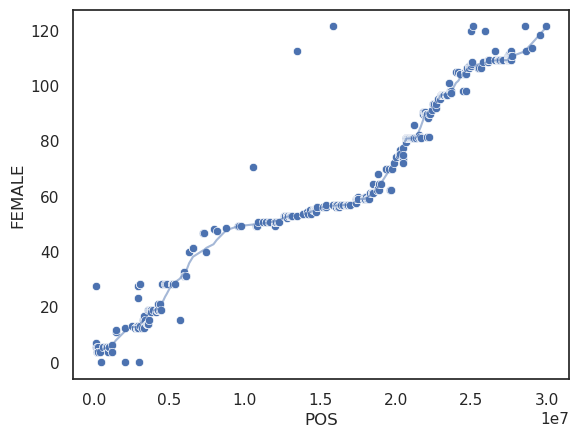

In [35]:

sns.scatterplot(data = lg, x = "POS", y = "FEMALE")
sns.lineplot(data = lg, x = "POS", y = "smoothed", alpha = 0.5)

<Axes: xlabel='POS', ylabel='FEMALE'>

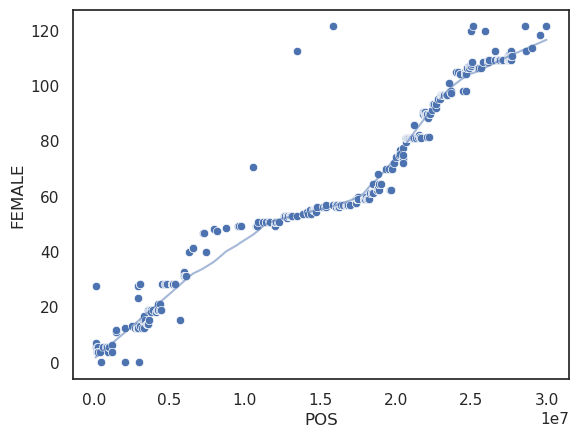

In [20]:

sns.scatterplot(data = lg, x = "POS", y = "FEMALE")
sns.lineplot(data = lg, x = "POS", y = "smoothed", alpha = 0.5)

In [8]:
lg

CHR       POS  NA  NA1    MALE   FEMALE  average   smoothed  \
0    LG4    107570   4    1   0.000    5.477   2.7385   0.024671   
1    LG4    115775   4    1   0.685   27.749  14.2170   0.024787   
2    LG4    135818   4    1   0.000    7.040   3.5200   0.025074   
3    LG4    193331   4    1   0.000    3.914   1.9570   0.025908   
4    LG4    208737   4    1   0.000    5.477   2.7385   0.026135   
..   ...       ...  ..  ...     ...      ...      ...        ...   
437  LG4  28560656   4    1  73.092  121.412  97.2520  64.074019   
438  LG4  28628422   4    1  64.884  112.380  88.6320  64.462500   
439  LG4  29023400   4    1  67.029  113.491  90.2600  66.730320   
440  LG4  29534601   4    1  68.152  118.494  93.3230  69.671008   
441  LG4  29973684   4    1  73.092  121.412  97.2520  72.198699   

     lowess_smoothing_fraction  
0                        0.175  
1                        0.175  
2                        0.175  
3                        0.175  
4                        0.175  
..                         ...  
437                      0.175  
438                      0.175  
439                      0.175  
440                      0.175  
441                      0.175  

[442 rows x 9 columns]

In [36]:
warnings.filterwarnings('ignore')
avgrecomb = []
link = pd.DataFrame()
marey = pd.read_csv("../../acer_cnat_dcyl_ssid_assembly/acer_linkage_scaffolding/lepwrap_denovo2/16_MareyMapsTrimmed/data.marey.trimmed.gz", 
            compression= "gzip", sep = "\t", header = None, names = ["CHR", "POS", "NA", "NA1", "MALE", "FEMALE"])
marey["average"] = ( marey["MALE"] + marey["FEMALE"] ) / 2
marey = marey[~marey["CHR"].str.contains("#")].reset_index(drop=True)
for parts in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]:
    lg = marey[marey["CHR"] == "LG" + str(parts + 1)].sort_values("POS").reset_index(drop=True)
    start = 0.001
    while start < 1:
        smoothed = pd.DataFrame(sm.nonparametric.lowess(exog=lg["POS"], endog=lg["average"], frac = start))
        smoothed.columns = ["POS", "average"]
        if ( smoothed["POS"].is_monotonic or 
        smoothed["POS"].iloc[::-1].is_monotonic ) and ( smoothed["average"].is_monotonic or 
                                                  smoothed["average"].iloc[::-1].is_monotonic ):
            break
        else:
            start = start + 0.001
            smoothed = pd.DataFrame(sm.nonparametric.lowess(exog=lg["POS"], endog=lg["average"], frac = start, it))
            smoothed.columns = ["POS", "average"]
    smoothed = smoothed.sort_values("POS").reset_index(drop=True)
    smoothed.loc[smoothed["average"] < 0, "average"] = 0
    lg["smoothed"] = smoothed["average"]
    lg = lg.sort_values("POS").reset_index(drop=True)
    lg["lowess_smoothing_fraction"] = start
    start = 0.001
    while start < 1:
        smoothed = pd.DataFrame(sm.nonparametric.lowess(exog=lg["POS"], endog=lg["FEMALE"], frac = start))
        smoothed.columns = ["POS", "FEMALE"]
        if ( smoothed["POS"].is_monotonic or 
        smoothed["POS"].iloc[::-1].is_monotonic ) and ( smoothed["FEMALE"].is_monotonic or 
                                                  smoothed["FEMALE"].iloc[::-1].is_monotonic ):
            break
        else:
            start = start + 0.001
            smoothed = pd.DataFrame(sm.nonparametric.lowess(exog=lg["POS"], endog=lg["FEMALE"], frac = start))
            smoothed.columns = ["POS", "FEMALE"]
    smoothed = smoothed.sort_values("POS").reset_index(drop=True)
    smoothed.loc[smoothed["FEMALE"] < 0, "FEMALE"] = 0
    lg["smoothed_FEMALE"] = smoothed["FEMALE"]
    lg = lg.sort_values("POS").reset_index(drop=True)
    lg["lowess_smoothing_fraction_FEMALE"] = start
    start = 0.001
    while start < 1:
        smoothed = pd.DataFrame(sm.nonparametric.lowess(exog=lg["POS"], endog=lg["MALE"], frac = start))
        smoothed.columns = ["POS", "MALE"]
        if ( smoothed["POS"].is_monotonic or 
        smoothed["POS"].iloc[::-1].is_monotonic ) and ( smoothed["MALE"].is_monotonic or 
                                                  smoothed["MALE"].iloc[::-1].is_monotonic ):
            break
        else:
            start = start + 0.001
            smoothed = pd.DataFrame(sm.nonparametric.lowess(exog=lg["POS"], endog=lg["MALE"], frac = start))
            smoothed.columns = ["POS", "MALE"]
    smoothed = smoothed.sort_values("POS").reset_index(drop=True)
    smoothed.loc[smoothed["MALE"] < 0, "MALE"] = 0
    lg["smoothed_MALE"] = smoothed["MALE"]
    lg = lg.sort_values("POS").reset_index(drop=True)
    lg["lowess_smoothing_fraction_MALE"] = start

10.542398131905252
15.601808701047169
6.644666551427923
12.27210351448154
8.06488918243768
10.887092204432838
17.173793286326298
11.290977234397138
19.124830611727358
10.812289249496033
11.785444330686156
16.523076606674383
24.387633108527844
12.387884115277105


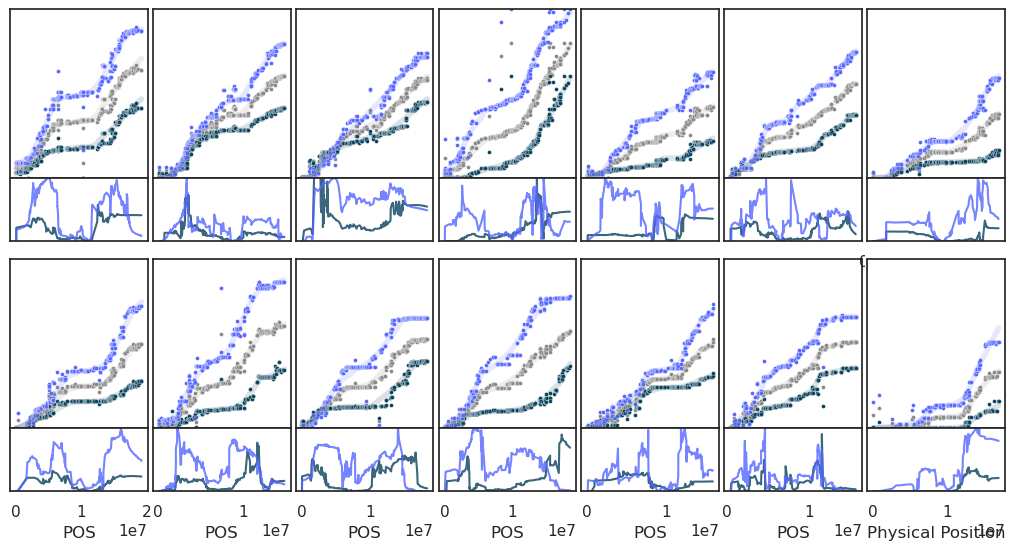

In [6]:
warnings.filterwarnings('ignore')
avgrecomb = []
link = pd.DataFrame()
sns.set(style="white")
fig = plt.figure(constrained_layout=True,figsize=(10,5))
subplots = fig.subfigures(2,7, hspace=0.5)
marey = pd.read_csv("../../acer_cnat_dcyl_ssid_assembly/acer_linkage_scaffolding/lepwrap_denovo2/16_MareyMapsTrimmed/data.marey.trimmed.gz", 
            compression= "gzip", sep = "\t", header = None, names = ["CHR", "POS", "NA", "NA1", "MALE", "FEMALE"])
marey["average"] = ( marey["MALE"] + marey["FEMALE"] ) / 2
marey = marey[~marey["CHR"].str.contains("#")].reset_index(drop=True)
for parts in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]:
    lg = marey[marey["CHR"] == "LG" + str(parts + 1)].sort_values("POS").reset_index(drop=True)
    start = 0.001
    while start < 1:
        smoothed = pd.DataFrame(sm.nonparametric.lowess(exog=lg["POS"], endog=lg["average"], frac = start))
        smoothed.columns = ["POS", "average"]
        if ( smoothed["POS"].is_monotonic or 
        smoothed["POS"].iloc[::-1].is_monotonic ) and ( smoothed["average"].is_monotonic or 
                                                  smoothed["average"].iloc[::-1].is_monotonic ):
            break
        else:
            start = start + 0.001
            smoothed = pd.DataFrame(sm.nonparametric.lowess(exog=lg["POS"], endog=lg["average"], frac = start))
            smoothed.columns = ["POS", "average"]
    smoothed = smoothed.sort_values("POS").reset_index(drop=True)
    smoothed.loc[smoothed["average"] < 0, "average"] = 0
    lg["smoothed"] = smoothed["average"]
    lg = lg.sort_values("POS").reset_index(drop=True)
    lg["lowess_smoothing_fraction"] = start
    start = 0.001
    while start < 1:
        smoothed = pd.DataFrame(sm.nonparametric.lowess(exog=lg["POS"], endog=lg["FEMALE"], frac = start))
        smoothed.columns = ["POS", "FEMALE"]
        if ( smoothed["POS"].is_monotonic or 
        smoothed["POS"].iloc[::-1].is_monotonic ) and ( smoothed["FEMALE"].is_monotonic or 
                                                  smoothed["FEMALE"].iloc[::-1].is_monotonic ):
            break
        else:
            start = start + 0.001
            smoothed = pd.DataFrame(sm.nonparametric.lowess(exog=lg["POS"], endog=lg["FEMALE"], frac = start))
            smoothed.columns = ["POS", "FEMALE"]
    smoothed = smoothed.sort_values("POS").reset_index(drop=True)
    smoothed.loc[smoothed["FEMALE"] < 0, "FEMALE"] = 0
    lg["smoothed_FEMALE"] = smoothed["FEMALE"]
    lg = lg.sort_values("POS").reset_index(drop=True)
    lg["lowess_smoothing_fraction_FEMALE"] = start
    start = 0.001
    while start < 1:
        smoothed = pd.DataFrame(sm.nonparametric.lowess(exog=lg["POS"], endog=lg["MALE"], frac = start))
        smoothed.columns = ["POS", "MALE"]
        if ( smoothed["POS"].is_monotonic or 
        smoothed["POS"].iloc[::-1].is_monotonic ) and ( smoothed["MALE"].is_monotonic or 
                                                  smoothed["MALE"].iloc[::-1].is_monotonic ):
            break
        else:
            start = start + 0.001
            smoothed = pd.DataFrame(sm.nonparametric.lowess(exog=lg["POS"], endog=lg["MALE"], frac = start))
            smoothed.columns = ["POS", "MALE"]
    smoothed = smoothed.sort_values("POS").reset_index(drop=True)
    smoothed.loc[smoothed["MALE"] < 0, "MALE"] = 0
    lg["smoothed_MALE"] = smoothed["MALE"]
    lg = lg.sort_values("POS").reset_index(drop=True)
    lg["lowess_smoothing_fraction_MALE"] = start

    ax1 = subplots.flat[parts].subplots(2,1, 
                                        gridspec_kw={'height_ratios': [2, 0.75], 
                                                     'wspace':0, 'hspace':0})#, sharey = True)
    if lg["smoothed"].is_monotonic:
        lg["MALERECOMBRATE"] = np.nan
        lg["MALERECOMBRATE"][0] = 0
        lg["FEMALERECOMBRATE"] = np.nan
        lg["FEMALERECOMBRATE"][0] = 0
        for inter in list(range(len(lg)))[1:]:
            interval = inter - 1
            lg["MALERECOMBRATE"][inter] = ( lg["smoothed_MALE"][interval] - lg["smoothed_MALE"][inter] ) / (( lg["POS"][interval] - lg["POS"][inter] ) / 1000000)
            lg["FEMALERECOMBRATE"][inter] = ( lg["smoothed_FEMALE"][interval] - lg["smoothed_FEMALE"][inter] ) / (( lg["POS"][interval] - lg["POS"][inter] ) / 1000000)
        sns.scatterplot(x = lg["POS"], y = lg["average"], s=8, 
                        color = "#878787", ax=ax1[0])
        sns.lineplot(x = lg["POS"], y = lg["smoothed"], alpha = 0.15, 
                     lw = 4, color = "#878787", ax=ax1[0])
        sns.scatterplot(x = lg["POS"], y = lg["MALE"], s=8, 
                        color = "#08415C", ax=ax1[0])
        sns.lineplot(x = lg["POS"], y = lg["smoothed_MALE"], alpha = 0.15, 
                     lw = 4, color = "#08415C", ax=ax1[0])
        sns.scatterplot(x = lg["POS"], y = lg["FEMALE"], s=8, 
                        color = "#5465FF", ax=ax1[0])
        sns.lineplot(x = lg["POS"], y = lg["smoothed_FEMALE"], alpha = 0.15, 
                     lw = 4, color = "#5465FF", ax=ax1[0])
        sns.lineplot(data = lg, x = "POS", y = "MALERECOMBRATE", 
             color = "#08415C", alpha = 0.8, lw = 1.5, ax=ax1[1])
        sns.lineplot(data = lg, x = "POS", y = "FEMALERECOMBRATE", 
             color = "#5465FF", alpha = 0.8, lw = 1.5, ax=ax1[1])
        print(lg["FEMALERECOMBRATE"].max())
    else:
        lg["smoothed"] = np.abs(lg["smoothed"] - lg["smoothed"].max())
        lg["average"] = np.abs(lg["average"] - lg["average"].max())
        lg["smoothed_MALE"] = np.abs(lg["smoothed_MALE"] - lg["smoothed_MALE"].max())
        lg["MALE"] = np.abs(lg["MALE"] - lg["MALE"].max())
        lg["smoothed_FEMALE"] = np.abs(lg["smoothed_FEMALE"] - lg["smoothed_FEMALE"].max())
        lg["FEMALE"] = np.abs(lg["FEMALE"] - lg["FEMALE"].max())
        lg["MALERECOMBRATE"] = np.nan
        lg["MALERECOMBRATE"][0] = 0
        lg["FEMALERECOMBRATE"] = np.nan
        lg["FEMALERECOMBRATE"][0] = 0
        for inter in list(range(len(lg)))[1:]:
            interval = inter - 1
            lg["MALERECOMBRATE"][inter] = ( lg["smoothed_MALE"][interval] - lg["smoothed_MALE"][inter] ) / (( lg["POS"][interval] - lg["POS"][inter] ) / 1000000)
            lg["FEMALERECOMBRATE"][inter] = ( lg["smoothed_FEMALE"][interval] - lg["smoothed_FEMALE"][inter] ) / (( lg["POS"][interval] - lg["POS"][inter] ) / 1000000)
        sns.scatterplot(x = lg["POS"], y = lg["average"], s=8, 
                        color = "#878787", ax=ax1[0])
        sns.lineplot(x = lg["POS"], y = lg["smoothed"], alpha = 0.15, 
                     lw = 4, color = "#878787", ax=ax1[0])
        sns.scatterplot(x = lg["POS"], y = lg["MALE"], s=8, 
                        color = "#08415C", ax=ax1[0])
        sns.lineplot(x = lg["POS"], y = lg["smoothed_MALE"], alpha = 0.15, 
                     lw = 4, color = "#08415C", ax=ax1[0])
        sns.scatterplot(x = lg["POS"], y = lg["FEMALE"], s=8, 
                        color = "#5465FF")
        sns.lineplot(x = lg["POS"], y = lg["smoothed_FEMALE"], alpha = 0.15, 
                     lw = 4, color = "#5465FF", ax=ax1[0])
        sns.lineplot(data = lg, x = "POS", y = "MALERECOMBRATE", 
             color = "#08415C", alpha = 0.8, lw = 1.5, ax=ax1[1])
        sns.lineplot(data = lg, x = "POS", y = "FEMALERECOMBRATE", 
             color = "#5465FF", alpha = 0.8, lw = 1.5, ax=ax1[1])
        print(lg["FEMALERECOMBRATE"].max())
    ax1.flat[0].xaxis.set_visible(False)
    ax1.flat[0].yaxis.set_visible(False)
    ax1.flat[1].yaxis.set_visible(False)
    ax1.flat[1].set_ylim([0, lg["FEMALERECOMBRATE"].max()])
    ax1.flat[0].set_ylim([0, marey["FEMALE"].max()])
    ax1.flat[0].set(ylabel = "Genetic Position")
    #plt.ylim(0, 115)
    #plt.xlabel("Physical Position (bp)")
    #plt.ylabel("Genetic Position (cM)")
    #link = pd.concat([link, lg])
    #for i in list(range(len(lg))):
    #    try:
    #        avgrecomb = avgrecomb + [(( lg["smoothed"][i + 1] - lg["smoothed"][i] ) / (( lg["POS"][i + 1] - lg["POS"][i] )/1000000))]
    #    except:
    #        pass

plt.xlabel("Physical Position")
fig.tight_layout()
plt.show()

In [7]:
lg

CHR       POS  NA  NA1    MALE  FEMALE  average   smoothed  \
0    LG14     68678  14    1   0.685  18.447   9.5660   0.221975   
1    LG14    788115  14    1   4.110  23.931  14.0205   0.365679   
2    LG14   2599633  14    1   0.000   6.707   3.3535   0.836177   
3    LG14   3138677  14    1   0.000   0.000   0.0000   0.999425   
4    LG14   3149410  14    1   0.000   0.000   0.0000   1.002620   
..    ...       ...  ..  ...     ...     ...      ...        ...   
165  LG14  16590356  14    1  12.537  60.868  36.7025  39.629240   
166  LG14  16597069  14    1  12.537  60.133  36.3350  39.653352   
167  LG14  16729038  14    1  12.537  61.604  37.0705  40.121487   
168  LG14  16927768  14    1  19.067  61.604  40.3355  40.807581   
169  LG14  16943802  14    1  19.067  61.604  40.3355  40.862056   

     lowess_smoothing_fraction  smoothed_FEMALE  \
0                         0.22         0.000000   
1                         0.22         0.000000   
2                         0.22         0.875857   
3                         0.22         1.487934   
4                         0.22         1.500131   
..                         ...              ...   
165                       0.22        68.393507   
166                       0.22        68.460518   
167                       0.22        69.773978   
168                       0.22        71.738505   
169                       0.22        71.896344   

     lowess_smoothing_fraction_FEMALE  smoothed_MALE  \
0                               0.351       0.000000   
1                               0.351       0.000000   
2                               0.351       0.000000   
3                               0.351       0.000000   
4                               0.351       0.000000   
..                                ...            ...   
165                             0.351      15.264715   
166                             0.351      15.281970   
167                             0.351      15.621014   
168                             0.351      16.134960   
169                             0.351      16.176879   

     lowess_smoothing_fraction_MALE  MALERECOMBRATE  FEMALERECOMBRATE  
0                              0.22        0.000000          0.000000  
1                              0.22       -0.000000         -0.000000  
2                              0.22       -0.000000          0.483493  
3                              0.22       -0.000000          1.135487  
4                              0.22       -0.000000          1.136382  
..                              ...             ...               ...  
165                            0.22        2.573451         10.028344  
166                            0.22        2.570381          9.982368  
167                            0.22        2.569117          9.952791  
168                            0.22        2.586154          9.885405  
169                            0.22        2.614332          9.844027  

[170 rows x 15 columns]